Let's dive deep into the Activations and Gradients in a Multi-Layer Perceptron language model for subreddit names.

This loosely follows part 3 of Andrej Karpathy's excellent [makemore](https://github.com/karpathy/makemore); go and check that out first.
However he used a list of US names, where we're going to use subreddit names.
See [Makemore Subreddits - Part 2 MLP](https://skeptric.com/makemore-subreddits-part-2-mlp/) for the original Multi-Layer Perceptron following from [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).

::: {.callout-note}
This is a Jupyter notebook you can [download the notebook](https://github.com/EdwardJRoss/skeptric/blob/master/makemore-subreddits-part-3-activation-gradient/index.ipynb) or [view it on Kaggle](https://www.kaggle.com/code/edwardjross/makemore-subreddits-part-3-activation-gradient).
:::

# Loading the Data

This is largely similar to [Part 1](https://skeptric.com/makemore-subreddits-part-1-bigram-model/) where we get the most common subreddit names from  [All Subreddits and Relations Between Them](https://www.kaggle.com/datasets/thedevastator/all-subreddits-and-relations-between-them).

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import random
import csv
from pathlib import Path
from collections import Counter
from tqdm.auto import trange, tqdm

Filter to subreddits that:

* Have at least 1000 subscribers
* Are not archived
* Are safe for work
* And are not quarantined

Note that you need to have [downloaded subreddits.csv](https://skeptric.com/resources/subreddits.csv.bz2) (and uncompresed if appropriate).

In [2]:
data_path = Path('./data')
min_subscribers = 1_000

with open(data_path / 'subreddits.csv', 'r') as f:
    names = [d['name'] for d in csv.DictReader(f) 
             if int(d['subscribers'] or 0) >= min_subscribers
             and d['description']
             and d['type'] != 'archived'
             and d['nsfw'] == 'f'
             and d['quarantined'] == 'f']
    
len(names)
random.seed(42)
random.shuffle(names)

N = len(names)

names_train = names[:int(0.8*N)]
names_val = names[int(0.8*N):int(0.9*N)]
names_test = names[int(0.9*N):]


for name in names_train[:10]:
    print(name)

len(names_train), len(names_val), len(names_test)

splunk
thenwa
soylent
factorio
christinaricci
blues
vegancheesemaking
goldredditsays
reformed
nagoya


(26876, 3359, 3360)

# Compile the Data

Now convert the dataset into something that the model can easily work with.
First represent all the character tokens as consecutive integers.
We create a special `PAD_CHAR` with index 0 to represent tokens outside of the sequence.

In [3]:
PAD_CHAR = '.'
PAD_IDX = 0

i2s = sorted(set(''.join(names_train)))
assert PAD_CHAR not in i2s
i2s.insert(PAD_IDX, PAD_CHAR)

s2i = {s:i for i, s in enumerate(i2s)}

V = len(i2s)

def compile_dataset(names, block_size, PAD_CHAR=PAD_CHAR, s2i=s2i):
    X, y = [], []
    for name in names:
        padded_name = PAD_CHAR * block_size + name + PAD_CHAR
        padded_tokens = [s2i[c] for c in padded_name]
        for *context, target in zip(*[padded_tokens[i:] for i in range(block_size+1)]):
            X.append(context)
            y.append(target)
    return torch.tensor(X), torch.tensor(y)


block_size = 3

X, y = compile_dataset(names_train, block_size)
X_val, y_val = compile_dataset(names_val, block_size)
X_test, y_test = compile_dataset(names_test, block_size)

X.shape, y.shape

(torch.Size([330143, 3]), torch.Size([330143]))

# Review: Multi-Layer Perceptron

We will start with the Multi-Layer perceptron implementation from part 2

In [4]:
default_m = 30
default_h = 200

class MLP:
    def __init__(self, m=default_m, h=default_h, V=V, block_size=block_size):
        self.m = m
        self.h = h
        self.V = V
        self.block_size = block_size
        
        # Word embedding layer
        self.C = torch.randn(V, m)

        # First hidden layer
        self.H = torch.randn(block_size * m, h)
        self.d = torch.randn(h)

        # Second hidden layer
        self.U = torch.randn(h, V)
        self.b = torch.randn(V)
        
    def parameters(self):
        return [self.C, self.H, self.d, self.U, self.b]
    
    def requires_grad_(self, requires_grad=True):
        for p in self.parameters():
            p.requires_grad_(requires_grad)
        return self
    
    def zero_grad(self):
        for p in self.parameters():
            p.grad = None
        return self
    
    def forward(self, X):
        self.embeddings = self.C[X]
        self.hidden_layer = self.embeddings.view(X.shape[0], self.block_size * self.m) @ self.H + self.d
        self.hidden_activations =  torch.tanh(self.hidden_layer)
        self.output_logits = self.hidden_activations @ self.U + self.b
        return self.output_logits
    
    def __call__(self, X):
        return self.forward(X)

So we can start from a randomly initialised MLP:

In [5]:
mlp = MLP().requires_grad_()

with torch.no_grad():
    preds_val = mlp(X_val)
    val_loss = F.cross_entropy(preds_val, y_val).item()
val_loss

27.776723861694336

And code to sample from it (which gives random output):

In [6]:
def sample(mlp, pad_idx=PAD_IDX, block_size=block_size, i2s=i2s, generator=None):
    ans = []
    state = torch.tensor([[pad_idx] * block_size])
    while True:
        probs = mlp(state).softmax(axis=1)
        next_idx = torch.multinomial(mlp(state).softmax(axis=1), 1, generator=generator)
        state = torch.concat([state, next_idx], axis=1)[:,1:]
        
        next_idx = next_idx[0,0].item()
        if next_idx == pad_idx:
            return ''.join(ans)
        ans.append(i2s[next_idx])
        
sample(mlp)

'qaxtgkseh9ekyf9uokp29euoy4a7igiareg'

And code to train it:

In [7]:
batch_size = 32
val_step = 100

def train(model, n_step, lr, batch_size=batch_size, val_step=val_step, X=X, y=y, X_val=X_val, y_val=y_val, callback=None):
    losses, val_losses = [], []
    
    for step in trange(n_step):
        model.training = True  # NEW: support models that are different at train and inference time
        idx = torch.randint(0, len(X), (batch_size,))
    
        model.zero_grad()
        logits = model(X[idx])
        loss =  F.cross_entropy(input=logits, target=y[idx])
        losses.append((step, loss.item()))
        loss.backward()

        # NEW: Support injecting a callback to do some mutation
        if callback is not None:
            callback(**locals())
        
        for p in model.parameters():
            p.data -= p.grad * lr(step, n_step)
        
        if step % val_step == 0:
            model.training = False # NEW: support models that are different at train and inference time
            with torch.no_grad():
                preds_val = model(X_val)
                val_loss = F.cross_entropy(preds_val, y_val).item()
                val_losses.append((step, val_loss))

    model.training = False # NEW
    return losses, val_losses

In [8]:
losses, val_losses = train(mlp, n_step=50_000, lr=lambda step, n_step: 0.1)

  0%|          | 0/50000 [00:00<?, ?it/s]

The loss decreases quickly from a very high value, and then slowly descends.

2.6191823482513428

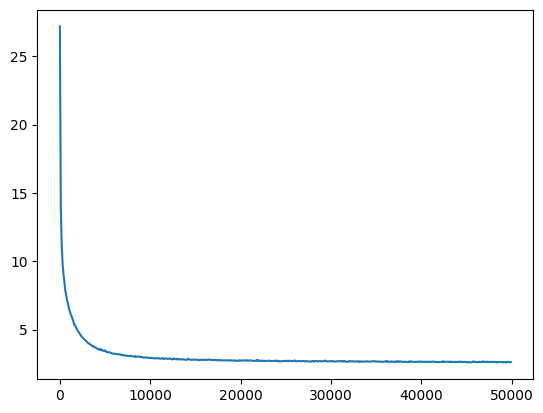

In [9]:
val_loss_step, val_loss_value = zip(*val_losses)

plt.plot(val_loss_step, val_loss_value)

baseline_loss = val_loss_value[-1]
baseline_loss

We get samples that are much less random, but still don't really seem like subreddit names.

In [10]:
for _ in range(20):
    print(sample(mlp))

lolleckingurs
r64onfrimen
caryimalcuraogardcartfgatulgeterheisting
clan
voumg
hvur
stagb
monconts
vart
scaromark
uprycherce
wing
lok
crteyrar
ling
jerkeymentfumearnight
kurcudver
learovedx
osarenetroor
ct2ivzenmirdur34therrertifar


# Fixing Initialisation

The loss starts off very high giving the "hockey-stick" shaped loss curve.
We can fix this by starting the weights in a better place.

The initial loss is very high:

In [11]:
mlp = MLP()

with torch.no_grad():
    preds_val = mlp(X_val)
    val_loss = F.cross_entropy(preds_val, y_val).item()
val_loss

29.860868453979492

A good baseline model is the constant model that assigns each token in the vocabulary an equal probability

In [12]:
constant_model = 1/V * torch.ones(size=(len(X_val), V))

Such a model has a 1/V probability of having the correct prediction, and so the loss will be -log(1/V)

In [13]:
-torch.log(torch.tensor(1/V)).item()

3.6375861167907715

This is accurate to a very good approximation, and much better than the random weights.

In [14]:
F.cross_entropy(constant_model, y_val).item()

3.637585163116455

## Walking through the model

We want to initialise the weights so that the model predicts close to a random distribution of outputs.

Let's step through the layers of our current model for a batch of training data to understand what is currently happening:

```
self.embeddings = self.C[X]
self.hidden_layer = self.embeddings.view(X.shape[0], self.block_size * self.m) @ self.H + self.d
self.hidden_activations =  torch.tanh(self.hidden_layer)
self.output_logits = self.hidden_activations @ self.U + self.b
```

In [15]:
with torch.no_grad():
    batch = mlp(X[:32])

The embeddings have a sort of standard normal distribution; slightly distorted by the item frequency.

```
self.C = torch.randn(V, m)
...
self.embeddings = self.C[X]
```

(torch.Size([32, 3, 30]), tensor(0.9805))

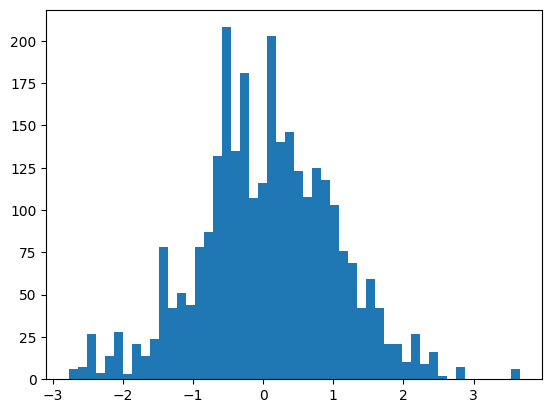

In [16]:
plt.hist(mlp.embeddings.view(-1), bins=50);
mlp.embeddings.shape, mlp.embeddings.std()

The first hidden layer performs a linear transformation.

```
# First hidden layer
self.H = torch.randn(block_size * m, h)
self.d = torch.randn(h)
...
self.hidden_layer = self.embeddings.view(X.shape[0], self.block_size * self.m) @ self.H + self.d
```

In index notation the hidden layer $h$ looks like:

$$h_{i,k} = \sum_{j=1}^{m \times {\rm block\_size}} e_{i,j} H_{j,k} + d_{i,k}$$

And assuming the variables are all independent, and that the embeddings e and matrix H each consist of elements of zero mean and equal standard deviation then $\mathbb{E}(h) = 0$ and 

$$ \mathbb{V}(h_{i,k}) = (m \times {\rm block\_size}) \mathbb{V}(e) \mathbb{V}(H) + \mathbb{V}(d)$$

So in particular here we've set all the element variances to 1, and so the output variance should be:

In [17]:
mlp.block_size * mlp.m + 1

91

It's pretty close to this (with some random error)

(torch.Size([32, 200]), tensor(83.0976))

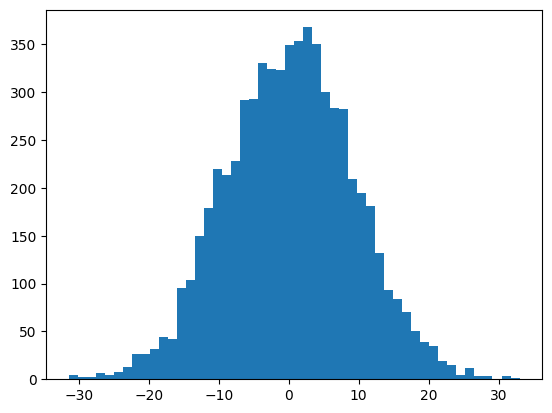

In [18]:
plt.hist(mlp.hidden_layer.view(-1), bins=50);
mlp.hidden_layer.shape, mlp.hidden_layer.var()

We then perform a tanh transformation, which squishes values far from 1 towards 1.

```
self.hidden_activations =  torch.tanh(self.hidden_layer)
```

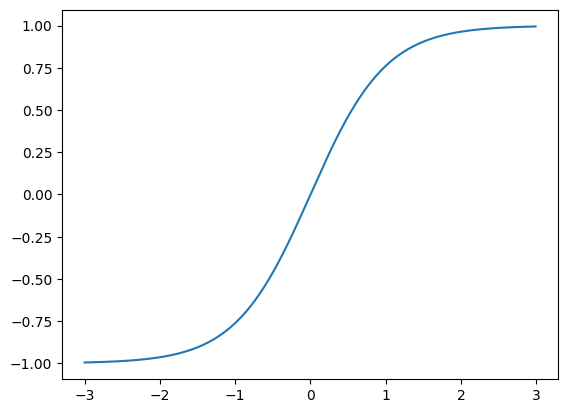

In [19]:
x = torch.arange(-3, 3, step=0.01)
plt.plot(x, torch.tanh(x));

Consequently we get all our values squished around -1 and 1

(torch.Size([32, 200]), tensor(0.9154))

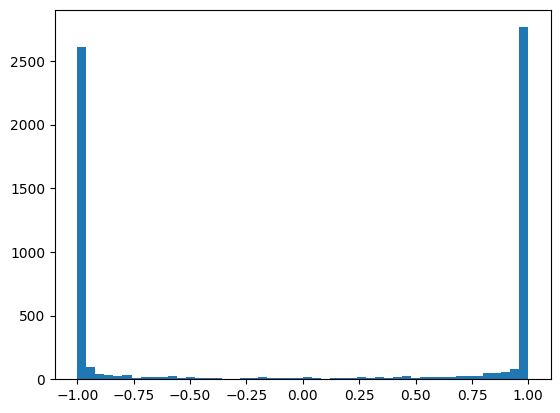

In [20]:
plt.hist(mlp.hidden_activations.view(-1), bins=50);
mlp.hidden_activations.shape, mlp.hidden_activations.var()

Many of the activations are above 0.99, which means the gradient is $\tanh'(x) = 1-\tanh^2(x) < 0.02$, which can lead to gradient underflow.

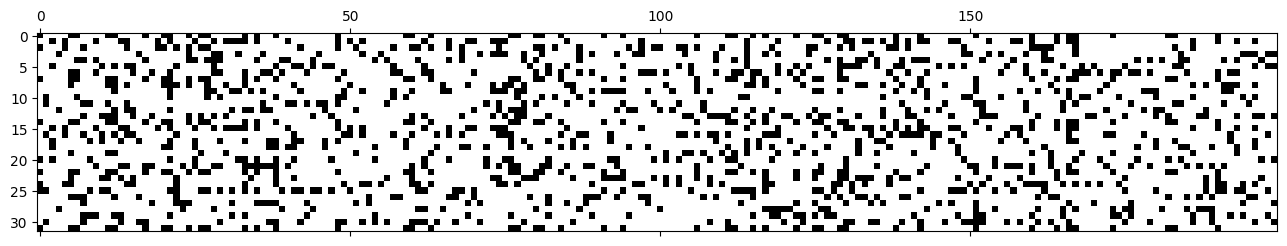

In [21]:
plt.matshow(mlp.hidden_activations.abs() > 0.99, cmap='gray', interpolation='nearest');

The output logits are then mostly either U + b or -U + b, and so they are approximately normal.

```
self.output_logits = self.hidden_activations @ self.U + self.b
```

It has a huge variance, approximately $${\rm hidden\_size} \times  \mathbb{V}(U) + \mathbb{V}(b) =  \rm hidden\_size+ 1$$

In [22]:
mlp.h + 1

201

(torch.Size([32, 38]), tensor(190.1738))

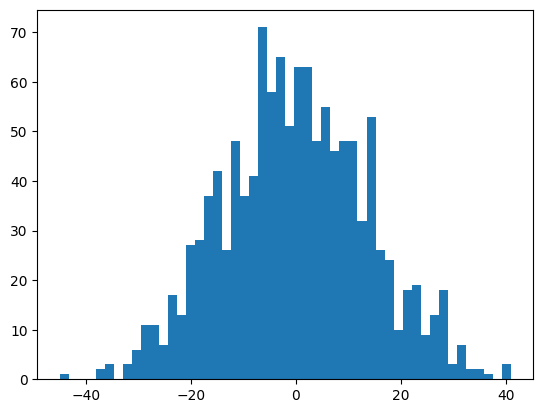

In [23]:
plt.hist(mlp.output_logits.view(-1), bins=50);
mlp.output_logits.shape, mlp.output_logits.var()

This means the logits fluctuate wildly and the predictions are very extreme with a very high probability prediction:

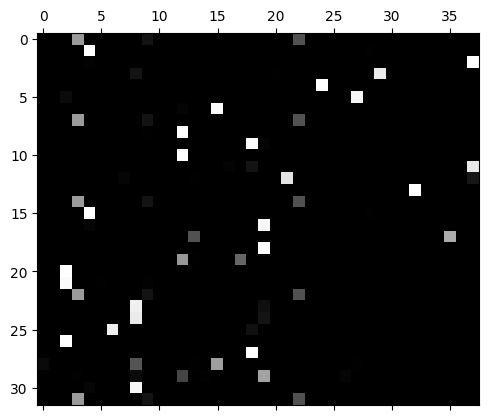

In [24]:
plt.matshow(mlp.output_logits.softmax(axis=1), cmap='gray');

We can fix these simply by scaling down the activations; this is much more important in deep networks where these effects compound often leading to exploding or vanishing gradients.

This is explained clearly in Xavier Glorot and Yoshua Bengio's [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) where they derive the variance *ignoring non-linearities* for the backward and forward pass and suggest initialising with

$$ w \sim U\left(-\frac{\sqrt{6}}{\sqrt{n_{\rm in} + n_{\rm out}}}, \frac{\sqrt{6}}{\sqrt{n_{\rm in} + n_{\rm out}}}\right)$$

Alternatively their analysis suggests you could also use

$$ w \sim \mathcal{N}\left(\mu=0, \sigma = \frac{\sqrt{2}}{\sqrt{n_{\rm in} + n_{\rm out}}}\right)$$

or approximately, $w \sim \mathcal{N}\left(\mu=0, \sigma = 1/\sqrt{n_{\rm in}}\right)$ and this latter form is called *Xavier initialisation* or *Glorot initialisation*.
They show these allow training CNNs up to 9 layers deep which was difficult without this.

In [Delving Deep into Rectifiers](https://arxiv.org/abs/1502.01852) He, Zheng, Ren, and Sun take into account the ReLU non-linearity and show you need to introduce a gain of $\sqrt{2}$ (the *He initialisation* or *Kaiming Initialisation* after the first author), which allows them to go from 22 layers to 30.

For other non-linearities Siddharth Krishna Kumar derivies the variance in [On weight initialization in deep neural networks](https://arxiv.org/abs/1704.08863) of a differentiable activation function $g$ and uses a local expansion to derive an initialisation of

$$ w \sim \mathcal{N}\left(\mu=0, \sigma = \frac{1}{\left|g'(0)\right|\sqrt{n (1 + g(0))^2}}\right) $$

For tanh this suggests a gain of 1, but as Andrej Karpathy argues in this lecture since tanh is contractive the gain *must* be more than 1, but this would require a higher-order approximation.

PyTorch has a gain of 5/3, but [no one remembers why](https://discuss.pytorch.org/t/calculate-gain-tanh/20854).
It's likely an estimate of the variance of $\tanh$ under a standard normally distributed input:

$$ \begin{align}
\mathbb{V}\left[\tanh\right] &= \mathbb{E}\left[\left(\tanh - \mathbb{E}(\tanh)\right)^2\right] \\
                             &= \mathbb{E}\left[\tanh^2\right] \\
                             &= \int_{-\infty}^{\infty} \left(\frac{1}{\sqrt{2 \pi}} e^{-x^2/2} \right) \tanh^2(x)\,{\rm d}x \\
                             & \approx 0.394
\end{align}$$

To normalise the gain we need to divide by the standard deviation (the square root of the variance) ${\rm gain} \approx 1/\sqrt{0.394} \approx 1.59 \approx 5/3$ (where the last term introduces an error of around 5%).

In general even if it is difficult to calculate the variance (for example because we're unsure of the input distribution), it can be empirically derived, as in [All you Need is a Good Init](https://arxiv.org/abs/1511.06422) by Mishkin and Matas with their iterative Layer-sequential Unit Variance (LSUV) method.

In any case it won't matter with our 1-layer MLP, and other methods such as batch/layer normalisation, skip connections, and better optimisers have made these less important (but you [can train a transformer](https://arxiv.org/abs/2302.10322) without the normalisation and skip connections).

For simplicity we'll use Kaiming initialisation, setting the initialisation of the biases to a very low number and further scaling down the output logits to get a better initial loss.

In [25]:
def fix_init(mlp, bias_variance=1e-4, output_variance=1e-1):
    with torch.no_grad():
        mlp.H *= 1/(mlp.block_size*mlp.m)**0.5
        mlp.d *= bias_variance ** 0.5

        mlp.U *= output_variance**0.5/(mlp.h**0.5)
        mlp.b *= bias_variance ** 0.5
    return mlp
        
mlp = fix_init(MLP()).requires_grad_()

We can see out initial loss is much lower, and closer to random.

In [26]:
with torch.no_grad():
    preds_val = mlp(X_val)
    val_loss = F.cross_entropy(preds_val, y_val).item()
    
val_loss

3.64780330657959

In [27]:
F.cross_entropy(torch.ones_like(preds_val), y_val).item()

3.637585163116455

As before we can step through the layers

In [28]:
with torch.no_grad():
    preds = mlp(X[:32])

The hidden pre-activations are now standard normal

(torch.Size([32, 200]), tensor(1.0259))

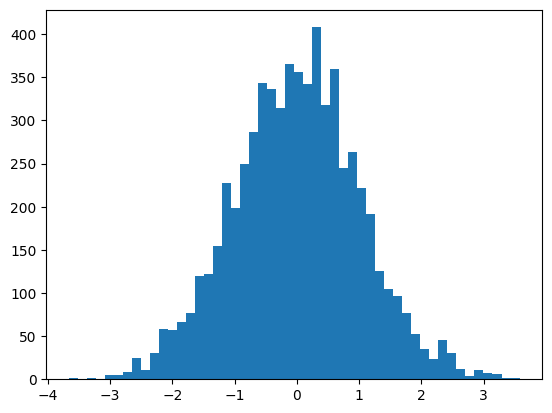

In [29]:
plt.hist(mlp.hidden_layer.view(-1), bins=50);
mlp.hidden_layer.shape, mlp.hidden_layer.var()

The activations are slightly saturated, but uniform-ish.

(torch.Size([32, 200]), tensor(0.3962))

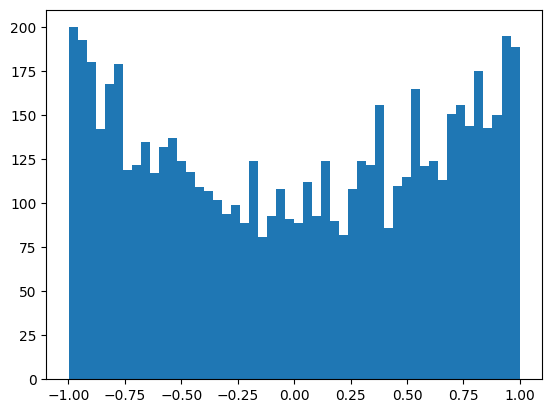

In [30]:
plt.hist(mlp.hidden_activations.view(-1), bins=50);
mlp.hidden_activations.shape, mlp.hidden_activations.var()

The output layer is now standard normal with the variance we set.

(torch.Size([32, 38]), tensor(0.1852))

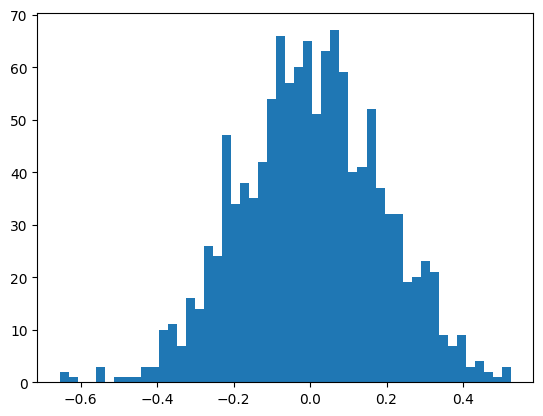

In [31]:
plt.hist(mlp.output_logits.view(-1), bins=50);
mlp.output_logits.shape, mlp.output_logits.std()

The predicted probabilities are much more uniform.

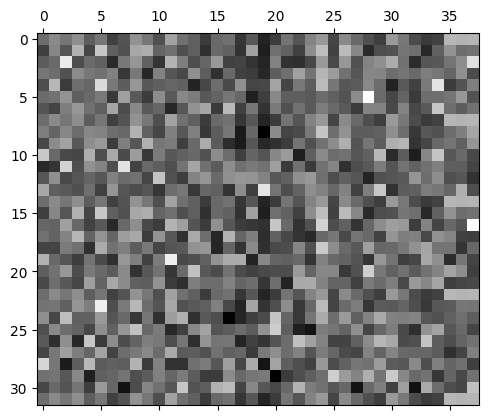

In [32]:
plt.matshow(mlp.output_logits.softmax(axis=1), cmap='gray')

In [33]:
losses, val_losses = train(mlp, n_step=50_000, lr=lambda step, n_step: 0.1)

  0%|          | 0/50000 [00:00<?, ?it/s]

The loss doesn't have as sharp an initial drop-off and reaches a lower value (before it was ~2.6)

(2.4480857849121094, '93.47% of baseline loss')

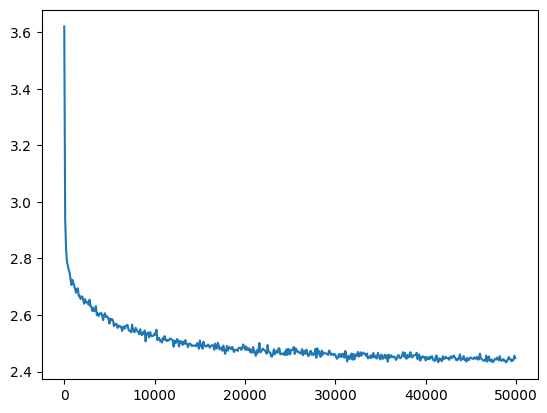

In [34]:
val_loss_step, val_loss_value = zip(*val_losses)

plt.plot(val_loss_step, val_loss_value)

fix_init_loss = val_loss_value[-1]

fix_init_loss, f'{fix_init_loss / baseline_loss:0.2%} of baseline loss'

We can run samples but they're not qualitatively better than before:

In [35]:
for _ in range(20):
    print(sample(mlp))

cata
sokemolos
clsybeafwensterthewlukening
therez
breadrycoonn
kritefactreamancoonscotterry
balarcare
coreporn
clang
neleng
cretages
reddits
comporn
curans
ristoryardsteton
nongoreddit
terbateas
millippertoockpharnothenesek
acepapertrole
deundumpstbroknv


# Batch Norm

Another way to control the distribution of the pre-activations is to rescale them to be in that distribution.
The challenge here is that we need to estimate the distribution of the weights somehow.
[Batch Norm](http://proceedings.mlr.press/v37/ioffe15.pdf) does this by calculating the statistics across a batch, which works both to normalise and regularise, but coupling examples across a batch makes the process more complicated and error prone.

To implement it we need to add:

* Learnable shift and scale parameters
* Fixed eps
* In the forward
    - normalise based on batch statistics
    - rescale with shift and scale parameters
 
Let's also track how the statistics change over time

In [36]:
class MLPBatchNorm(MLP):
    def __init__(self, m=default_m, h=default_h, V=V, block_size=block_size, bn_eps=1e-8):
        super().__init__(m=m, h=h, V=V, block_size=block_size)
        # New stuff
        self.bn_scale = torch.ones((1,h))
        self.bn_shift = torch.zeros((1,h))
        self.bn_eps = bn_eps

        # Track statistics for debugging
        self.bn_means = []
        self.bn_vars = []
        
    def parameters(self):
        return super().parameters() + [self.bn_scale, self.bn_shift]
    
    def forward(self, X, bn_mean=None, bn_var=None):
        self.embeddings = self.C[X]
        self.hidden_layer = self.embeddings.view(X.shape[0], self.block_size * self.m) @ self.H + self.d
        # New stuff; allow passing in a batch norm mean and variance for debugging
        μ = self.hidden_layer.mean(dim=0, keepdim=True) if bn_mean is None else bn_mean
        σ2 = self.hidden_layer.var(dim=0, keepdim=True) if bn_var is None else bn_var
        self.hidden_bn = self.bn_scale * (self.hidden_layer - μ) / (σ2 + self.bn_eps) ** 0.5 + self.bn_shift        
        self.hidden_activations =  torch.tanh(self.hidden_bn)

        # Track statistics only in training (not validation) for debugging
        if self.training:
            self.bn_means.append(μ.detach())
            self.bn_vars.append(σ2.detach())
        # End new stuff
        self.output_logits = self.hidden_activations @ self.U + self.b
        return self.output_logits
    

In [37]:
mlp = fix_init(MLPBatchNorm()).requires_grad_()

In [38]:
losses, val_losses = train(mlp, n_step=50_000, lr=lambda step, n_step: 0.1)

  0%|          | 0/50000 [00:00<?, ?it/s]

Training this we get a similar loss value as before:

(2.4308383464813232, '99.30% of fix_init loss')

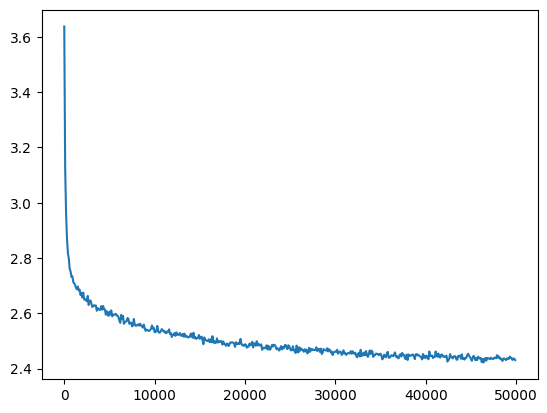

In [39]:
val_loss_step, val_loss_value = zip(*val_losses)

plt.plot(val_loss_step, val_loss_value)

bn_loss = val_loss_value[-1]

bn_loss, f'{bn_loss / fix_init_loss:0.2%} of fix_init loss'

*But* there's a problem, we can no longer make predictions on a single example because we normalise it away when calculating statistics:

In [40]:
mlp(X_val[:1])

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddBackward0>)

One way to handle this is to use the batch norm mean and variation on the training set

In [41]:
with torch.no_grad():
    preds = mlp(X)
    preact = mlp.hidden_layer
    bn_mean = preact.mean(dim=0)
    bn_var = preact.var(dim=0)

For each one of the 200 dimensions we have a mean and a standard deviation

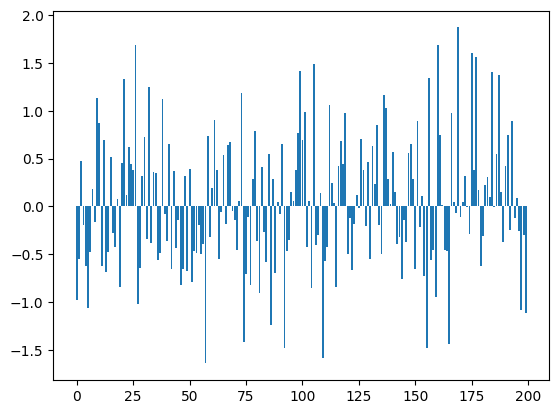

In [42]:
plt.bar(range(len(bn_mean)), bn_mean);

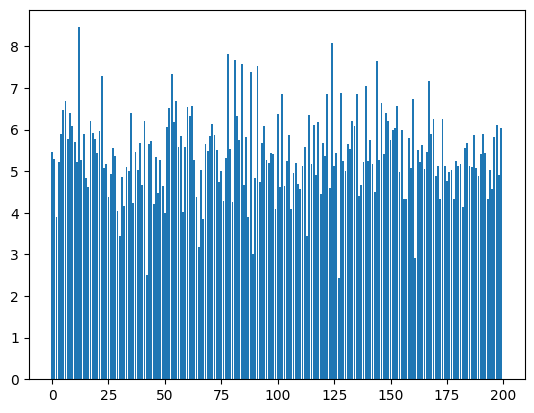

In [43]:
plt.bar(range(len(bn_mean)), bn_var);

We can use these population statistics as the batch norm mean and variance.
This also means that the predictions will be independent of the other items in the batch.

In [44]:
mlp.forward(X_val[:1], bn_mean, bn_var)

tensor([[-2.2420, -4.6427, -2.1474, -1.2763, -2.2146, -2.6077, -3.2863, -3.3461,
         -3.4700, -3.0928, -2.5705, -2.5806,  2.0783,  2.1519,  3.0222,  1.6728,
          1.3640,  2.1493,  1.9894,  1.2325,  1.4388,  0.6066,  0.8470,  1.6142,
          2.5117,  1.8061,  0.8732,  1.9734, -1.2449,  1.3586,  2.1918,  2.8410,
          1.2704,  0.9921,  1.4396, -0.9299, -0.2703, -0.8756]],
       grad_fn=<AddBackward0>)

We get essentially the same loss here as well (but if there were distribution shift between the training and validation sets then there could be a substantial difference using the validation statistics, which may not be possible in an online setting).

In [45]:
with torch.no_grad():
    preds_val = mlp.forward(X_val, bn_mean, bn_var)
    val_loss = F.cross_entropy(preds_val, y_val).item()

val_loss, f'{val_loss / bn_loss:0.2%} of bn_loss loss'

(2.4395534992218018, '100.36% of bn_loss loss')

## Running statistics

Calculating the training statistics after is an additional step, could we *estimate* them on the fly?

Let's looks at the batch norm means

In [46]:
train_bn_means = torch.concat(mlp.bn_means)
train_bn_vars = torch.concat(mlp.bn_vars)
train_bn_means.shape

torch.Size([50000, 200])

Let's look at a single dimension of the hidden layer.
Each point is the average value of the output over a single batch, it changes over time because of:

* random variations between batches
* changes in the parameters of the embeddings and hidden layer

We can see here that the value and variance changes over time (the final training set mean, `m_inf`, is in red)

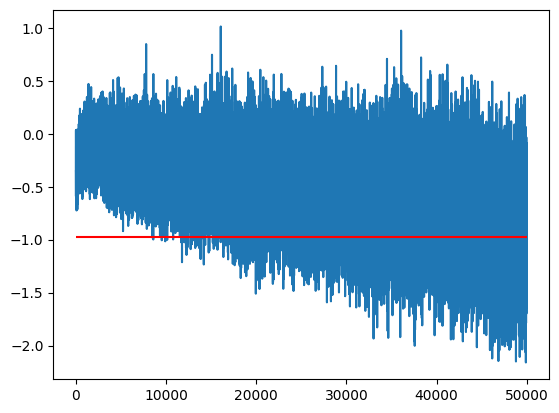

In [47]:
idx = 0
m = train_bn_means[:,0]
m_inf = bn_mean[0]
plt.plot(m)
plt.hlines(m_inf, 0, len(m), color='r');

This means if we took the simple average of points we severely mis-estimate the final value because it's moving.

In [48]:
m.mean(), m_inf

(tensor(-0.5176), tensor(-0.9794))

Similarly if we just took the last value it may mis-estimate because of the variance

In [49]:
m[-1], m_inf

(tensor(-0.6533), tensor(-0.9794))

One option between the two extremes is to use an [Exponential Moving Average](https://en.wikipedia.org/wiki/Exponential_smoothing) to track the value over time:

(-0.978546679019928, -0.9794382452964783)

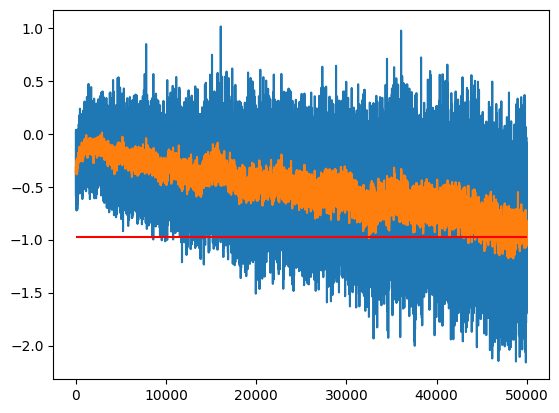

In [50]:
momentum = 0.1
m_ema = []
ema = m[0]
for m_i in m:
    ema = ema * (1 - momentum) + m_i * momentum
    m_ema.append(ema)

plt.plot(m)
plt.plot(m_ema)
plt.hlines(m_inf, 0, len(m), color='r')

ema.item(), m_inf.item()

The one hyperparameter we have to tune is the *momentum*; how much of the previous value do we keep in each step.

* A momentum that is too high means we will get too much variance (momentum = 1 gives the last value)
* A momentum that is too low will not respond quickly enough to the changes of parameters (too much bias)

(-0.43218255043029785, -0.9794382452964783)

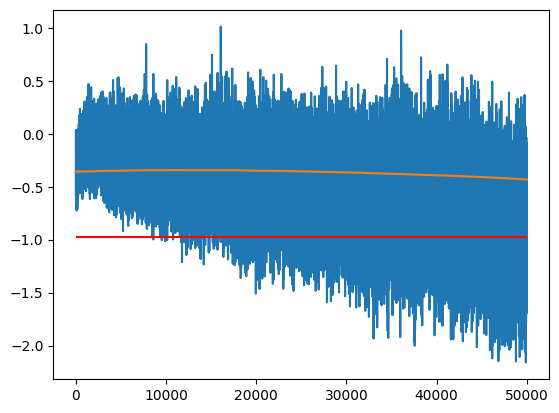

In [51]:
momentum = 0.00001
m_ema = []
ema = m[0]
for m_i in m:
    ema = ema * (1 - momentum) + m_i * momentum
    m_ema.append(ema)

plt.plot(m)
plt.plot(m_ema)
plt.hlines(m_inf, 0, len(m), color='r')

m_ema[-1].item(), m_inf.item()

The way this works is we get an exponentially decaying weight on old values; with a momentum $\alpha$, the exponential moving average estimates $y_i$ are given recursively as the weighted interpolation of the last estimate and the next value: $ y_i = (1-\alpha) y_{i-1} + \alpha x_i$
and so:

$$\begin{eqnarray}
y_0 &=& x_0 \\
y_1 &=& \alpha x_1 + (1 - \alpha) y_0 \\
    &=& \alpha x_1 + (1 - \alpha) x_0 \\
y_2 &=& \alpha x_2 + (1 - \alpha) y_1 \\
    &=& \alpha x_2 + (1 - \alpha) \alpha x_1 + (1- \alpha) ^2 x_0 \\
&\vdots& \\
y_n &=& \alpha x_n + (1 - \alpha) y_{n-1} \\
    &=& \alpha x_n + (1 - \alpha) \alpha x_{n-1} + (1 - \alpha)^2 \alpha x_{n-2} + \cdots + (1-\alpha)^{n-1} \alpha x_1 + (1- \alpha)^n x_0
\end{eqnarray}$$

The weights sum to 1 by the [geometric series](https://en.wikipedia.org/wiki/Geometric_series):

$$ 1 + (1 - \alpha) + (1-\alpha)^2 + \ldots + (1-\alpha)^{n-1} = \frac{1 - (1 - \alpha)^n}{\alpha}$$

For large enough $n$ we can ignore the last term and the terms approximately sum to 1

In [52]:
sum((1-momentum) ** torch.arange(len(m) - 1, -1, -1)) * momentum

tensor(0.3933)

We can then calcuate the exponential moving average quickly using the formula:

$$ y_n = \alpha \left((1-\alpha)^0 x_n + (1-\alpha)^1 x_{n-1} + \cdots + (1-\alpha)^n x_0  \right) + (1-\alpha)^{n+1} x_0$$

In [53]:
def fastema(z, momentum):
    weights = (1-momentum) ** torch.arange(z.shape[-1] - 1, -1, -1)
    return momentum * (z * weights).sum(axis=-1) + (1 - momentum)**(len(weights)) * z[...,0]

Check this gives the right answer

In [54]:
z = torch.rand(5)

momentum = 0.1
ema = z[0]
for m_i in z:
    ema = ema * (1 - momentum) + m_i * momentum

ema.item(), fastema(z, momentum).item(), torch.allclose(ema, fastema(z, momentum))

(0.5154919624328613, 0.5154920220375061, True)

It even works in two dimensions

In [55]:
z2 = torch.rand(5)
zz = torch.stack([z, z2])
zz.shape

torch.Size([2, 5])

Giving the same result over two dimensions

In [56]:
fastema(zz, momentum), fastema(z, momentum), fastema(z2, momentum)

(tensor([0.5155, 0.5326]), tensor(0.5155), tensor(0.5326))

We can now compare how good the estimate is for different values of momentum; in this case it's best around $[10^{-3}, 10^{-2}]$

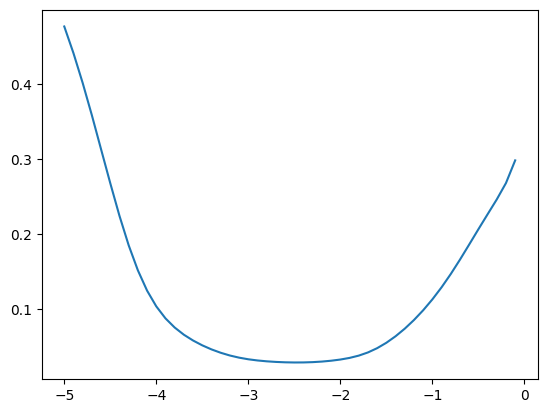

In [57]:
momentums_log10 = torch.arange(-5, 0, 0.1)
momentums = 10**momentums_log10
emas = [fastema(train_bn_means.transpose(0, 1), m) for m in momentums]

emas_rms_error = [((ema - bn_mean)**2).mean()**0.5 for ema in emas]

plt.plot(momentums_log10, emas_rms_error);

We get a similar result for the variances

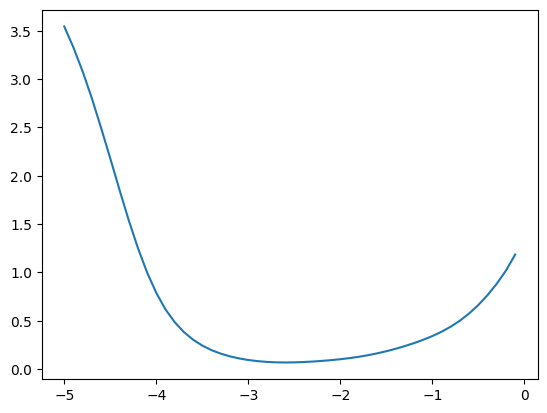

In [58]:
emas = [fastema(train_bn_vars.transpose(0, 1), m) for m in momentums]

emas_rms_error = [((ema - bn_var)**2).mean()**0.5 for ema in emas]

plt.plot(momentums_log10, emas_rms_error);

We can also look at the errors

tensor(0.0327)

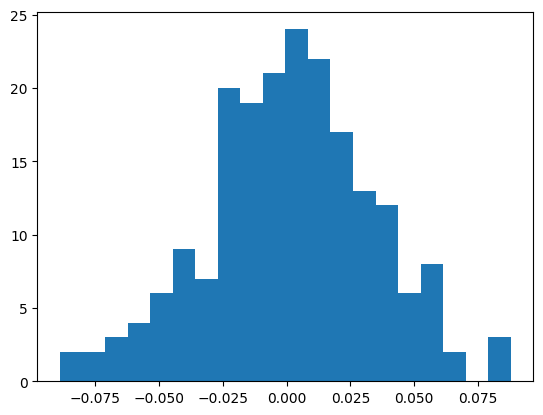

In [59]:
ema = fastema(train_bn_means.transpose(0, 1), momentum=0.001)
plt.hist(ema - bn_mean, bins=20);
((ema - bn_mean)**2).mean() ** 0.5

Note that the optimum momentum will be a factor of the *batch size*, as batch size increases:

* the variance within each step will decrease
* the number of steps in an epoch will decrease
* optimum momentum will increase

  0%|          | 0/5000 [00:00<?, ?it/s]

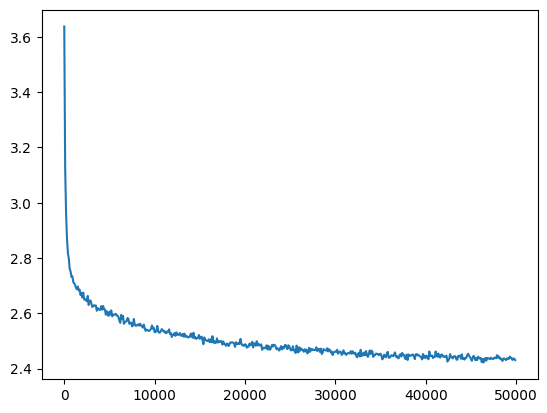

In [60]:
mlp = fix_init(MLPBatchNorm()).requires_grad_()
losses, val_losses = train(mlp, n_step=50_000//10, lr=lambda step, n_step: 0.1, batch_size=batch_size*10)

plt.plot(val_loss_step, val_loss_value);

In [61]:
train_bn_means = torch.concat(mlp.bn_means)
train_bn_vars = torch.concat(mlp.bn_vars)

with torch.no_grad():
    preds = mlp(X)
    preact = mlp.hidden_layer
    bn_mean = preact.mean(dim=0)
    bn_var = preact.var(dim=0)

We can see that the optimum momentum estimators get higher

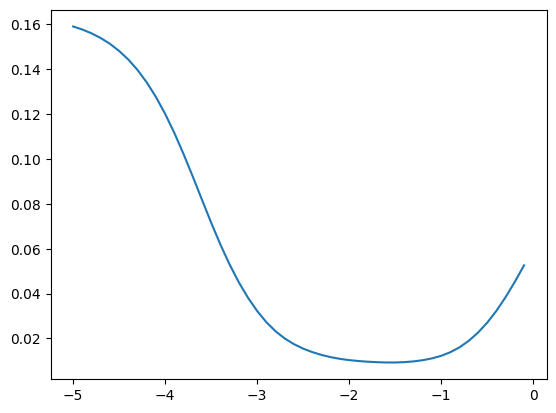

In [62]:
momentums_log10 = torch.arange(-5, 0, 0.1)
momentums = 10**momentums_log10
emas = [fastema(train_bn_means.transpose(0, 1), m) for m in momentums]

emas_rms_error = [((ema - bn_mean)**2).mean()**0.5 for ema in emas]

plt.plot(momentums_log10, emas_rms_error);

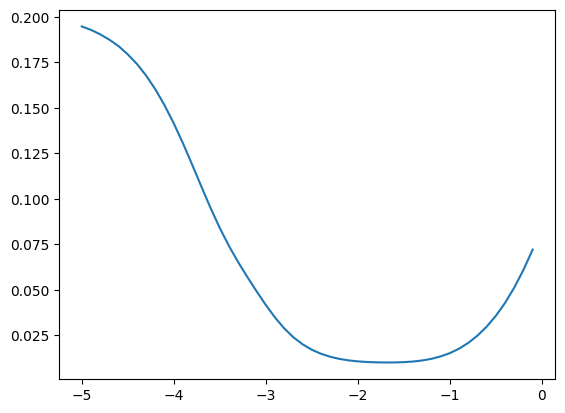

In [63]:
emas = [fastema(train_bn_vars.transpose(0, 1), m) for m in momentums]

emas_rms_error = [((ema - bn_var)**2).mean()**0.5 for ema in emas]

plt.plot(momentums_log10, emas_rms_error);

## Running statistics during training

We can now wrap this in our MLP:

* at training time collect the running statistics
* at inference time use the running statistics

Note that this only requires 2 extra variables per hidden dimension (1 for mean and 1 for variance).

In [64]:
class MLPBatchNorm(MLP):
    def __init__(self, m=default_m, h=default_h, V=V, block_size=block_size,
                 bn_eps=1e-8, bn_momentum = 0.001):
        super().__init__(m=m, h=h, V=V, block_size=block_size)
        self.bn_scale = torch.ones((1,h))
        self.bn_shift = torch.zeros((1,h))
        self.bn_eps = bn_eps
        # New stuff
        self.training = True
        self.bn_runvar =  torch.ones((1,h))
        self.bn_runmean = torch.zeros((1,h))
        self.bn_momentum = bn_momentum

        
    def parameters(self):
        return super().parameters() + [self.bn_scale, self.bn_shift]
    
    def forward(self, X):
        self.embeddings = self.C[X]
        self.hidden_layer = self.embeddings.view(X.shape[0], self.block_size * self.m) @ self.H + self.d
        if self.training:
            # Estimate batch mean and variance
            μ = self.hidden_layer.mean(dim=0, keepdim=True)
            σ2 = self.hidden_layer.var(dim=0, keepdim=True)
            
            # Update running totals
            with torch.no_grad():                
                self.bn_runmean = (1 - self.bn_momentum) * self.bn_runmean + \
                                  self.bn_momentum * μ
                self.bn_runvar = (1 - self.bn_momentum) * self.bn_runvar + \
                                 self.bn_momentum * σ2

        else:
            μ = self.bn_runmean
            σ2 = self.bn_runvar
            
        self.hidden_bn = self.bn_scale * (self.hidden_layer - μ) / (σ2 + self.bn_eps) ** 0.5 + self.bn_shift        
        self.hidden_activations =  torch.tanh(self.hidden_bn)
        self.output_logits = self.hidden_activations @ self.U + self.b
        return self.output_logits

This gives a similar loss as before

  0%|          | 0/50000 [00:00<?, ?it/s]

(2.427150011062622, '99.85% of batch norm loss')

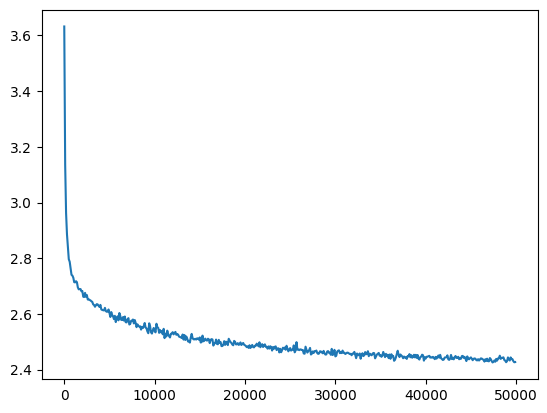

In [65]:
mlp = fix_init(MLPBatchNorm()).requires_grad_()
losses, val_losses = train(mlp, n_step=50_000, lr=lambda step, n_step: 0.1)

val_loss_step, val_loss_value = zip(*val_losses)

plt.plot(val_loss_step, val_loss_value)

bn_run_loss = val_loss_value[-1]

bn_run_loss, f'{bn_run_loss / bn_loss:0.2%} of batch norm loss'

But now we can evaluate it on single examples

In [66]:
mlp(X_val[:1])

tensor([[-1.8919, -4.8599, -1.5227, -1.5331, -1.6830, -2.4410, -3.0484, -2.9386,
         -3.2406, -3.1063, -2.3455, -3.1913,  2.2928,  1.8896,  2.5483,  2.3309,
          1.4567,  2.0108,  0.8814,  1.8238,  0.9417,  0.6373,  0.9153,  1.5311,
          2.3831,  1.3458,  1.2359,  2.2754, -0.9118,  1.6478,  2.0318,  2.5369,
          0.3390,  0.4008,  1.6127, -1.4685, -0.6556, -0.8556]],
       grad_fn=<AddBackward0>)

And in evaluation mode the resutls are independent of the batch size:

In [67]:
torch.allclose(mlp(X_val[:1]), mlp(X_val[:100])[:1])

True

Let's check our running statistics are similar to calculating them after the fact.

In [68]:
with torch.no_grad():
    preds = mlp(X)
    preact = mlp.hidden_layer
    bn_mean = preact.mean(dim=0, keepdim=True)
    bn_var = preact.var(dim=0, keepdim=True)

They're mostly similar, though some are substantially different.

tensor(0.0261)

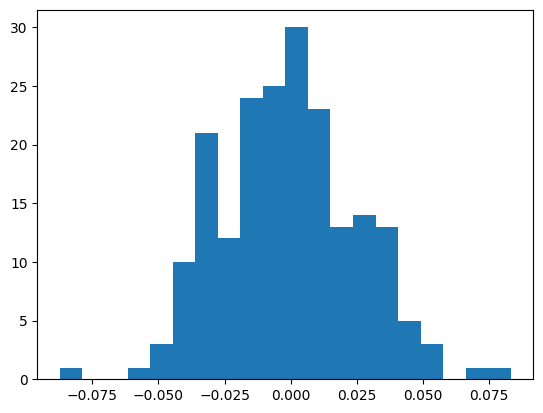

In [69]:
plt.hist(bn_mean - mlp.bn_runmean, bins=20);

((bn_mean - mlp.bn_runmean)**2).mean() ** 0.5

tensor(0.1085)

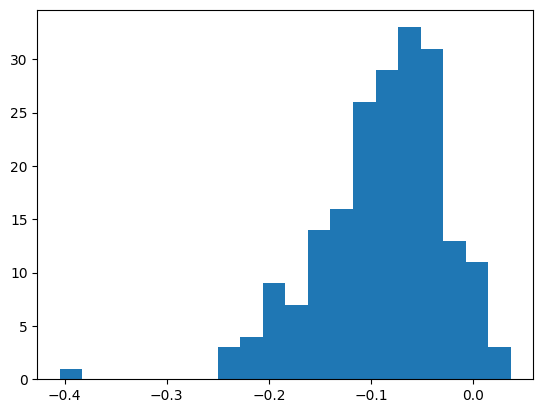

In [70]:
plt.hist(mlp.bn_runvar - bn_var, bins=20)

((bn_var - mlp.bn_runvar)**2).mean() ** 0.5

# Pytorchifying

With Batchnorm it's getting hard to maintain all this spaghetti code, so let's make it more modular like PyTorch.

We'll start off with a simple Module class that's a simple version of PyTorch's `nn.Module`

In [71]:
class MyModule:
    def __init__(self):
        self.training = True
        self._parameters = []
        
    def train(self, mode=True):
        self.training = mode
        return self
    
    def parameters(self):
        return self._parameters
        
    def requires_grad_(self, requires_grad=True):
        for p in self.parameters():
            p.requires_grad_(requires_grad)
        return self
    
    def zero_grad(self):
        for p in self.parameters():
            p.grad = None
        return self
    
    def forward(self, X):
        raise NotImplemented()
    
    def __call__(self, X):
        return self.forward(X)

    def __repr__(self):
        return f"{type(self).__name__}"

## Linear Layer

Then for our MLP we'll need a [Linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html), and we'll copy their initialisation:

$$ w \sim U\left(-1/\sqrt{\rm in\_features}, 1/\sqrt{\rm in\_features}\right) $$

Note this is missing the $\sqrt{3}$ from being uniform, and any activation specific gain.

Torch doesn't have a handy way of building a uniform distribution, so we will roll our own:

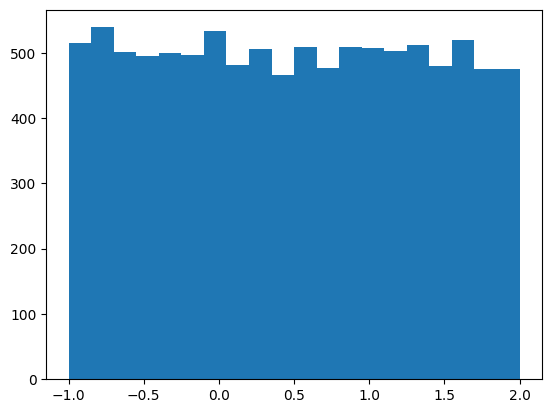

In [72]:
def rand_unif(shape, min_val, max_val):
    return torch.rand(shape) * (max_val - min_val) + min_val

plt.hist(rand_unif((10_000,), -1, 2), bins=20);

In [73]:
class MyLinear(MyModule):
    def __init__(self, in_features: int, out_features: int,
                 bias: bool = True):
        super().__init__()
        
        scale = 1/(in_features)**0.5
        
        self.weight = rand_unif((in_features, out_features), -scale, scale)
        self._parameters = [self.weight]

        if bias:
            self.bias = rand_unif(out_features, -scale, scale)
            self._parameters.append(self.bias)

    def __repr__(self):
        return f"{type(self).__name__}({self.weight.shape[0]}, {self.weight.shape[1]}, bias={hasattr(self, 'bias')})"
        
    def forward(self, X):
        self.out = X @ self.weight
        if hasattr(self, "bias"):
             self.out += self.bias
        return self.out

We can create a linear layer, and it has the appropriate mean and standard deviation

In [74]:
linear = MyLinear(100, 200)
linear

MyLinear(100, 200, bias=True)

In [75]:
linear.weight.mean(), 10 * (3)**0.5 * linear.weight.std()

(tensor(0.0002), tensor(0.9963))

As do the biases

In [76]:
linear.bias.mean(), 10 * (3)**0.5 * linear.bias.std()

(tensor(-0.0005), tensor(1.0303))

And it has the required parameters

In [77]:
[p.shape for p in linear.parameters()]

[torch.Size([100, 200]), torch.Size([200])]

And it converts a batch of 100 dimensional tensor into a batch of 200 dimensional tensors

In [78]:
linear(torch.randn(32, 100)).shape

torch.Size([32, 200])

In [79]:
linear_nobias = MyLinear(200, 100, bias=False)
[p.shape for p in linear_nobias.parameters()]

[torch.Size([200, 100])]

## Embedding Layer

We can similarly abstract the embedding layer, ala
[torch.nn.embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html), which is much simpler:

In [80]:
class MyEmbedding(MyModule):
    def __init__(self, num_embeddings, embedding_dim):
        super().__init__()
        self.weight = torch.randn(size=(num_embeddings, embedding_dim))
        
        self._parameters = [self.weight]

    def __repr__(self):
        return f"{type(self).__name__}{tuple(self.weight.shape)}"
        
    def forward(self, X):
        self.out = self.weight[X]
        return self.out

MyEmbedding(2,3)

MyEmbedding(2, 3)

## Batch Norm

We can similarly implement [`BatchNorm1d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html), which is more complex, but hides all the state inside the object which makes for a cleaner abstraction.

In [81]:
class MyBatchNorm1d(MyModule):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True):
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        
        self.affine = affine
        self.weight = torch.ones(num_features)
        self.bias = torch.zeros(num_features)
        if affine:
            self._parameters = [self.weight, self.bias]
        else:
            self._parameters = []
            
        self.track_running_stats = track_running_stats
        if track_running_stats:
            self.running_mean = torch.zeros(1, num_features)
            self.running_var = torch.ones(1, num_features)
        else:
            self.running_mean = None
            self.running_var = None

    def __repr__(self):
        return f"{type(self).__name__}({self.num_features}, eps={self.eps}, affine={self.affine})"
        
    def forward(self, X):
        if self.training:
            batch_mean = X.mean(dim=0, keepdim=True)
            batch_var = X.var(dim=0, keepdim=True, correction=0)
            
            if self.track_running_stats:
                with torch.no_grad():
                    self.running_mean *= 1 - self.momentum
                    self.running_mean += self.momentum * batch_mean.view(-1)
                    
                    self.running_var *= 1 - self.momentum
                    # Following documentation in Pytorch BatchNorm1D
                    self.running_var += self.momentum * X.var(dim=0, keepdim=True, correction=1)
        else:
            batch_mean = self.running_mean
            batch_var = self.running_var
            
        self.out = self.weight * (X - batch_mean) / batch_var + self.bias
        return self.out

MyBatchNorm1d(5)

MyBatchNorm1d(5, eps=1e-05, affine=True)

## MLP

We now have most of the pieces, we just need to add a few more to create our MLP.

Firstly we will need our activations such as [`nn.Tanh`](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html):

In [82]:
class MyTanh(MyModule):
    def forward(self, X):
        self.out = torch.tanh(X)
        return self.out

And a way to [flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) our embeddings from each token (up to `block_size`) into a single tensor:

In [83]:
class MyFlatten(MyModule):
    def __init__(self, start_dim=1, end_dim=-1):
        super().__init__()
        self.start_dim = start_dim
        self.end_dim = end_dim

    def forward(self, X):
        return X.flatten(self.start_dim, self.end_dim)

In [84]:
embedding = MyEmbedding(V, default_m)(X[:32])
embedding.shape

torch.Size([32, 3, 30])

In [85]:
MyFlatten()(embedding).shape

torch.Size([32, 90])

And then we just need to stack them together in a [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) sequence of layers:

In [86]:
class MySequential(MyModule):
    def __init__(self, *args):
        super().__init__()
        self.layers = args

        self._parameters = [params for layer in self.layers for params in layer.parameters()]

    def __repr__(self):
        return f"{type(self).__name__}({self.layers})"

    def __getitem__(self, idx):
        return self.layers[idx]

    def forward(self, X):
        result = X
        for layer in self.layers:
            result = layer(result)
        return result

We can then build an MLP for a given embedding dimension, and set of hidden dimensions:

In [87]:
def get_mlp(m=default_m, hs=(default_h,), batch_norm=False, bias=False, V=V, block_size=block_size, activation_factory=lambda: MyTanh()):
    # First we embed the vectors and then flatten them
    layers = [MyEmbedding(V, m), MyFlatten()]
    
    # Then add the hidden layers
    in_sizes = [block_size * m] + list(hs)
    out_sizes = list(hs) + [V]
    for h_in, h_out in zip(in_sizes, out_sizes):
        layers.append(MyLinear(h_in, h_out, bias=bias))
        if batch_norm:
            layers.append(MyBatchNorm1d(num_features=h_out))
        layers.append(activation_factory())
    # Drop the last activation, since this is passed to Softmax
    layers.pop()

    return MySequential(*layers)

mlp = get_mlp(bias=True).requires_grad_()
mlp

MySequential((MyEmbedding(38, 30), MyFlatten, MyLinear(90, 200, bias=True), MyTanh, MyLinear(200, 38, bias=True)))

We can train this to get a similar results as before with fixed initialisation

  0%|          | 0/50000 [00:00<?, ?it/s]

(2.4358863830566406, '99.50% of fixed init loss')

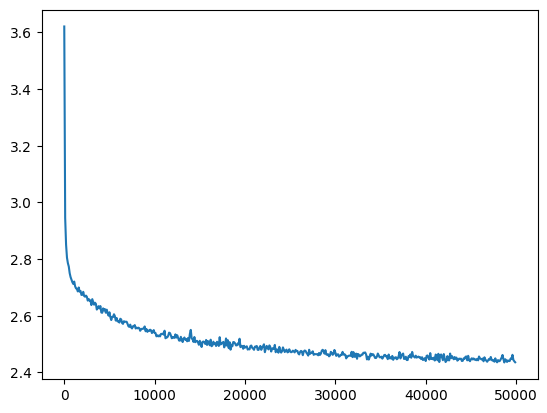

In [88]:
losses, val_losses = train(mlp, n_step=50_000, lr=lambda step, n_step: 0.1)

val_loss_step, val_loss_value = zip(*val_losses)

plt.plot(val_loss_step, val_loss_value)

mymlp_loss = val_loss_value[-1]

mymlp_loss, f'{mymlp_loss / fix_init_loss:0.2%} of fixed init loss'

# Going deeper

Now we have the framework for building deeper MLPs let's try to train and analyse some

## Without correction

Let's start with a plain 5 layer MLP without gain correction:

In [89]:
mlp = get_mlp(bias=True, m=10, hs=[100]*5).requires_grad_()
mlp

MySequential((MyEmbedding(38, 10), MyFlatten, MyLinear(30, 100, bias=True), MyTanh, MyLinear(100, 100, bias=True), MyTanh, MyLinear(100, 100, bias=True), MyTanh, MyLinear(100, 100, bias=True), MyTanh, MyLinear(100, 100, bias=True), MyTanh, MyLinear(100, 38, bias=True)))

In [90]:
with torch.no_grad():
    print('Initial Loss: %0.2f' % F.cross_entropy(mlp(X[:1000]), y[:1000]).item())

Initial Loss: 3.63


Let's look at the initial activations

In [91]:
def show_layer(i, t):
    print(f'layer {i} ({layer}): mean {t.mean():0.2f}, std {t.std():0.2f}, saturated: {((t.abs() > 0.97) * 1.0).mean():0.2%}')
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer})')

In [92]:
def show_layers(mlp, backward=False, classes=(MyTanh,), saturation_threshold = 0.97, figsize=(20,4), X=X_val[:32], y=y_val[:32]):
    preds = mlp(X)
    for layer in mlp:
        if hasattr(layer, 'out'):
            layer.out.retain_grad()
    loss = F.cross_entropy(input=preds, target=y)
    loss.backward()
    
    plt.figure(figsize=figsize) # width and height of the plot
    legends = []
    with torch.no_grad():
        for i, layer in enumerate(mlp):
            if isinstance(layer, classes):
                t = layer.out
                if backward:
                    t = t.grad
                print(f'layer {i} ({layer}): mean {t.mean():0.2f}, std {t.std():0.2f}, saturated: {((t.abs() > saturation_threshold) * 1.0).mean():0.2%}')
                hy, hx = torch.histogram(t, density=True)
                plt.plot(hx[:-1].detach(), hy.detach())
                legends.append(f'layer {i} ({layer})')

    
    plt.legend(legends);
    plt.title(('gradient' if backward else 'activation') + ' distribution')

    mlp.zero_grad()

layer 3 (MyTanh): mean 0.02, std 0.46, saturated: 0.00%
layer 5 (MyTanh): mean -0.00, std 0.27, saturated: 0.00%
layer 7 (MyTanh): mean 0.00, std 0.15, saturated: 0.00%
layer 9 (MyTanh): mean 0.01, std 0.10, saturated: 0.00%
layer 11 (MyTanh): mean 0.01, std 0.08, saturated: 0.00%


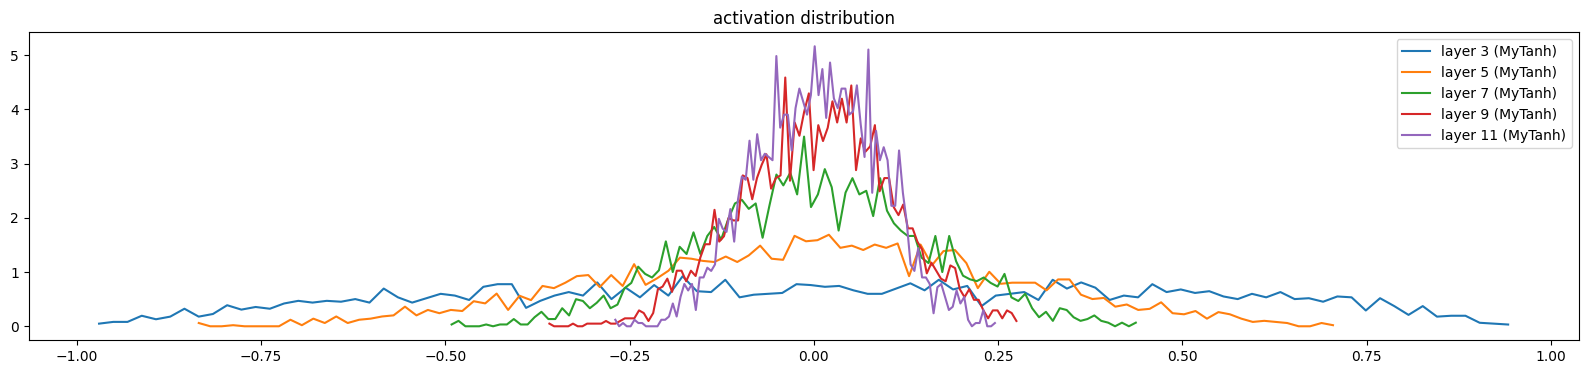

In [93]:
show_layers(mlp)

And gradients

layer 3 (MyTanh): mean 0.00, std 0.00, saturated: 0.00%
layer 5 (MyTanh): mean 0.00, std 0.00, saturated: 0.00%
layer 7 (MyTanh): mean 0.00, std 0.00, saturated: 0.00%
layer 9 (MyTanh): mean 0.00, std 0.00, saturated: 0.00%
layer 11 (MyTanh): mean -0.00, std 0.00, saturated: 0.00%


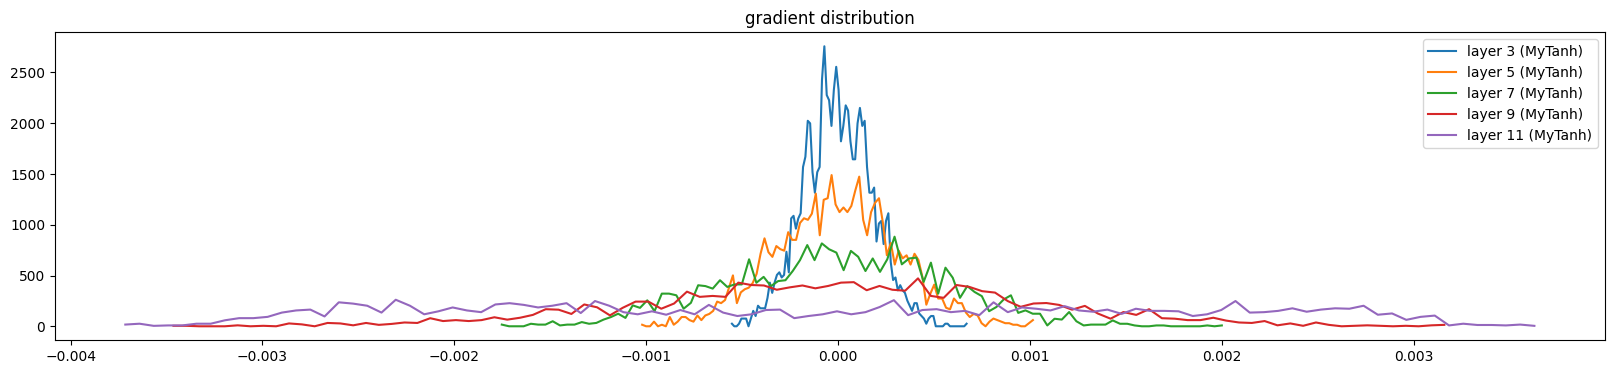

In [94]:
show_layers(mlp, backward=True)

And the weights

In [95]:
def show_weights(mlp, figsize=(20, 4), skip_embedding_layer=True, X=X_val[:32], y=y_val[:32]):
    preds = mlp(X)
    for layer in mlp:
        if hasattr(layer, 'out'):
            layer.out.retain_grad()
    loss = F.cross_entropy(input=preds, target=y)
    loss.backward()
    
    plt.figure(figsize=figsize)
    legends = []
    for i, p in enumerate(mlp.parameters()):
        if skip_embedding_layer and i == 0:
            continue
        t = p.grad
        if p.ndim == 2:
            print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'{i} {tuple(p.shape)}')
    plt.legend(legends)
    plt.title('weights gradient distribution')

    mlp.zero_grad()

weight  (30, 100) | mean -0.000015 | std 8.145859e-04 | grad:data ratio 7.634363e-03
weight (100, 100) | mean -0.000002 | std 8.332252e-04 | grad:data ratio 1.447422e-02
weight (100, 100) | mean -0.000002 | std 9.669473e-04 | grad:data ratio 1.674323e-02
weight (100, 100) | mean +0.000016 | std 1.014291e-03 | grad:data ratio 1.749655e-02
weight (100, 100) | mean -0.000012 | std 1.328168e-03 | grad:data ratio 2.303185e-02
weight  (100, 38) | mean +0.000000 | std 3.048425e-03 | grad:data ratio 5.262388e-02


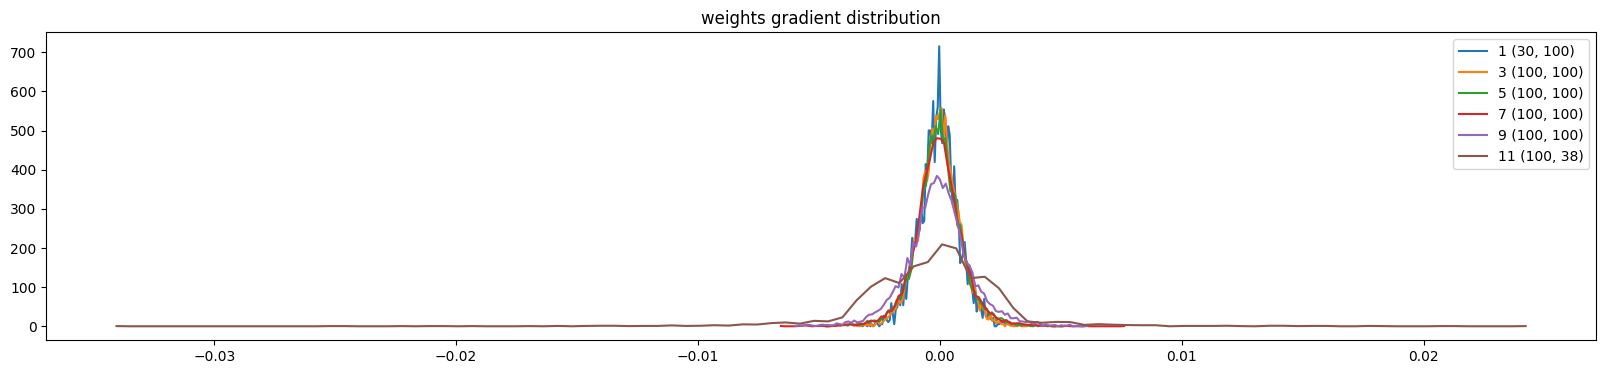

In [96]:
show_weights(mlp)

Let's try training it for 1000 steps and see how it changes; we will track the update-to-data ratio during training:

In [97]:
class UDCallback():
    def __init__(self):
        self.ud = []

    def __call__(self, model, lr, step, n_step, **kwargs):
        lr_value = lr(step, n_step)
        self.ud.append([(lr_value * p.grad.std() / p.data.std()).log10().item() for p in model.parameters()])

    def plot(self, figsize=(20, 4)):
        ud = self.ud
        plt.figure(figsize=figsize)
        legends = []
        for i,p in enumerate(mlp.parameters()):
          if p.ndim == 2:
            plt.plot([ud[j][i] for j in range(len(ud))])
            legends.append('param %d' % i)
        plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
        plt.legend(legends)

  0%|          | 0/1000 [00:00<?, ?it/s]

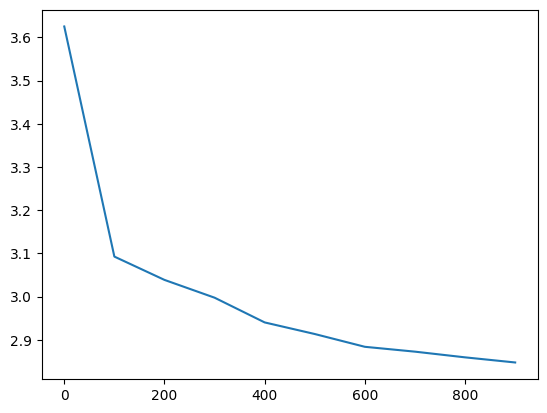

In [98]:
ud = UDCallback()

losses, val_losses = train(mlp, n_step=1_000, lr=lambda step, n_step: 0.1, callback=ud)

val_loss_step, val_loss_value = zip(*val_losses)

plt.plot(val_loss_step, val_loss_value)

The weights initially train at very different rates, but all but the output and embedding layer converge (to a slightly too high rate)

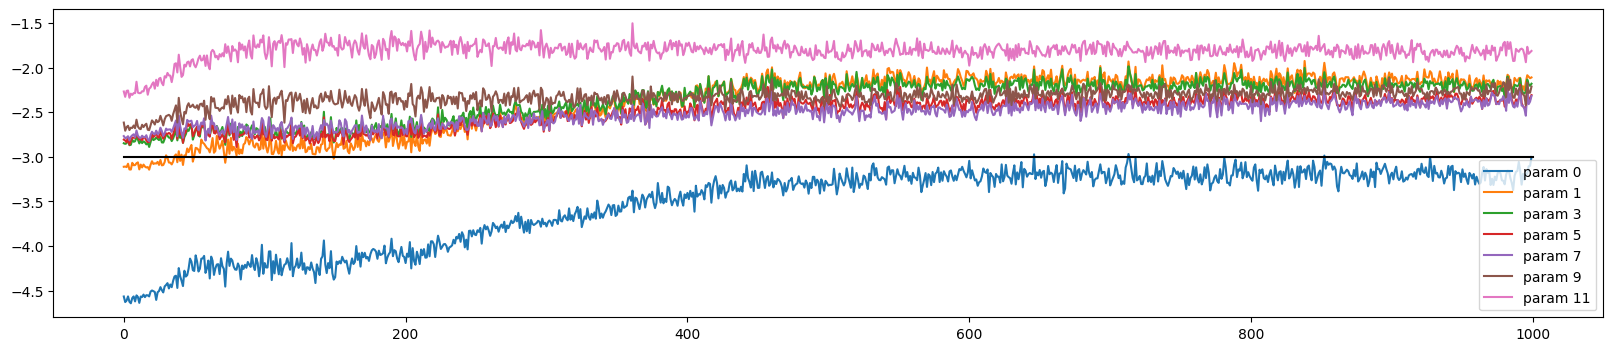

In [99]:
ud.plot()

The activations and gradients have largely sorted themselves out

layer 3 (MyTanh): mean 0.02, std 0.47, saturated: 0.00%
layer 5 (MyTanh): mean 0.00, std 0.33, saturated: 0.00%
layer 7 (MyTanh): mean -0.01, std 0.30, saturated: 0.00%
layer 9 (MyTanh): mean 0.02, std 0.33, saturated: 0.00%
layer 11 (MyTanh): mean 0.07, std 0.42, saturated: 0.00%


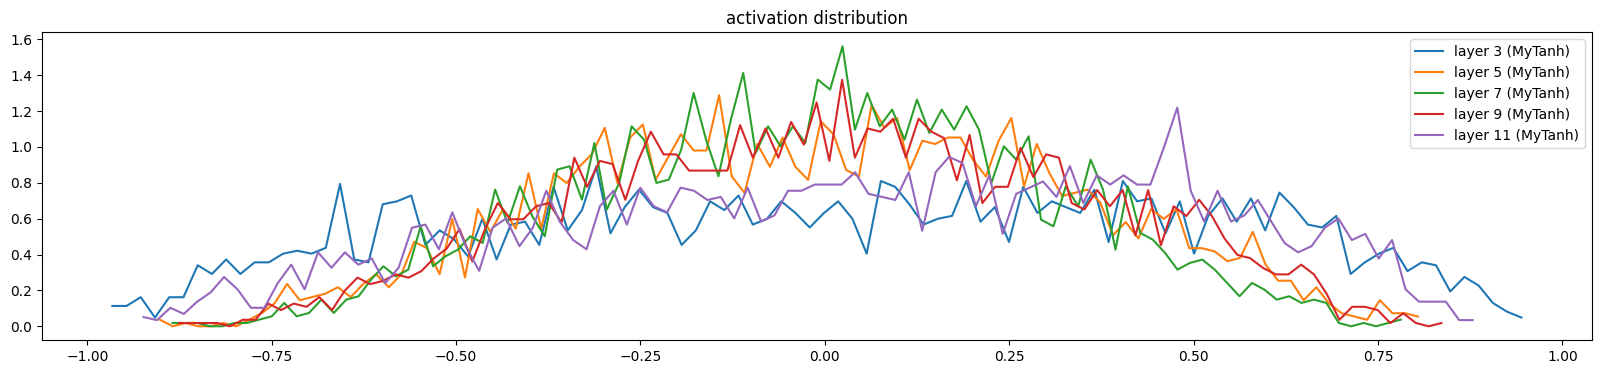

In [100]:
show_layers(mlp)

layer 3 (MyTanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (MyTanh): mean -0.00, std 0.00, saturated: 0.00%
layer 7 (MyTanh): mean -0.00, std 0.00, saturated: 0.00%
layer 9 (MyTanh): mean 0.00, std 0.00, saturated: 0.00%
layer 11 (MyTanh): mean 0.00, std 0.00, saturated: 0.00%


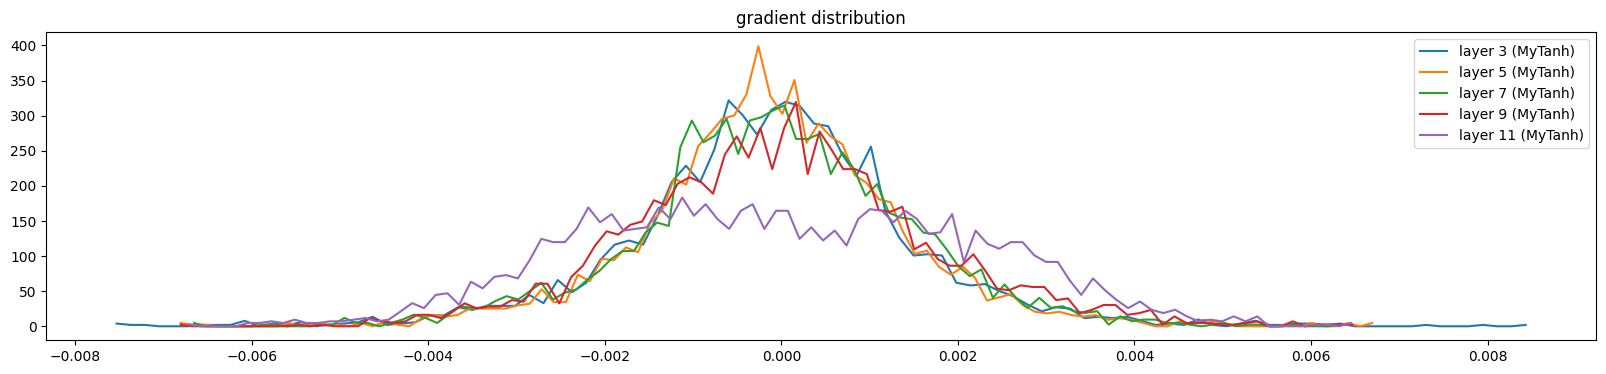

In [101]:
show_layers(mlp, backward=True)

And the weight gradients are more uniform

weight  (30, 100) | mean +0.000075 | std 7.344535e-03 | grad:data ratio 6.576340e-02
weight (100, 100) | mean -0.000005 | std 3.532875e-03 | grad:data ratio 5.843860e-02
weight (100, 100) | mean +0.000001 | std 2.672232e-03 | grad:data ratio 4.419371e-02
weight (100, 100) | mean -0.000003 | std 2.625167e-03 | grad:data ratio 4.310565e-02
weight (100, 100) | mean +0.000025 | std 3.583072e-03 | grad:data ratio 5.814888e-02
weight  (100, 38) | mean -0.000000 | std 1.289676e-02 | grad:data ratio 1.660140e-01


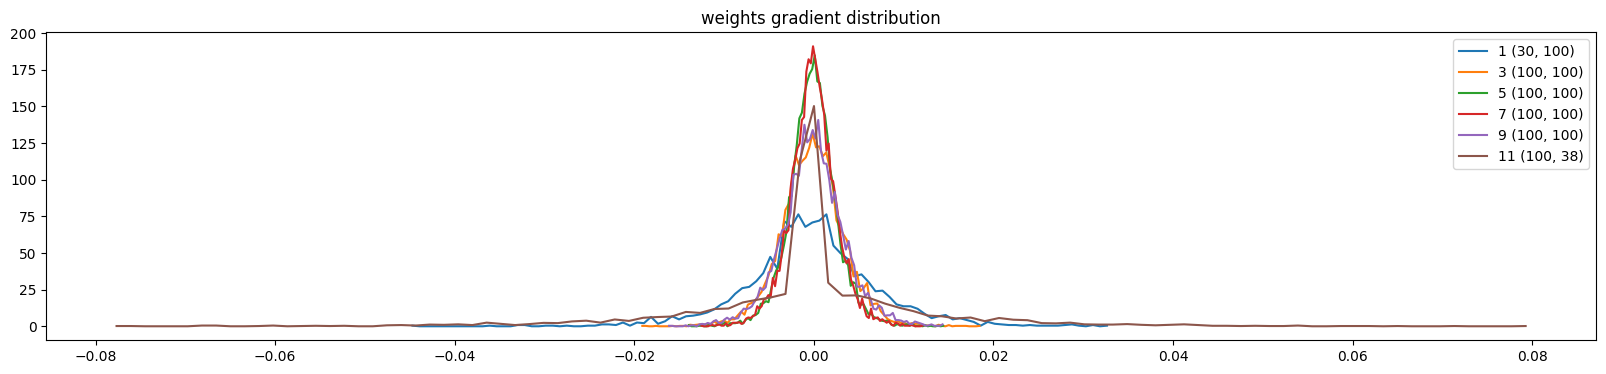

In [102]:
show_weights(mlp)

Even so it successfully trains

  0%|          | 0/50000 [00:00<?, ?it/s]

(2.4107613563537598, '98.48% of fixed init loss')

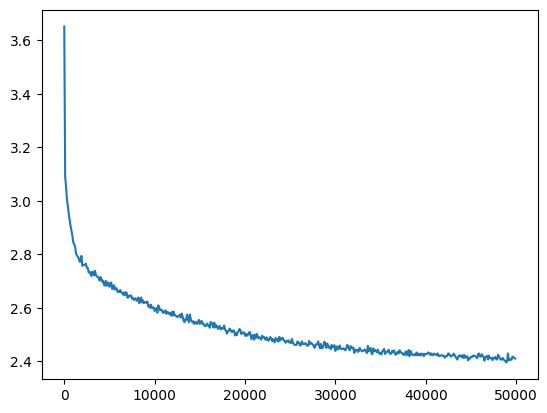

In [103]:
mlp = get_mlp(bias=True, m=10, hs=[100]*5).requires_grad_()

ud = UDCallback()

losses, val_losses = train(mlp, n_step=50_000, lr=lambda step, n_step: 0.1, callback=ud)

val_loss_step, val_loss_value = zip(*val_losses)

plt.plot(val_loss_step, val_loss_value)

l5_loss = val_loss_value[-1]

l5_loss, f'{l5_loss / fix_init_loss:0.2%} of fixed init loss'

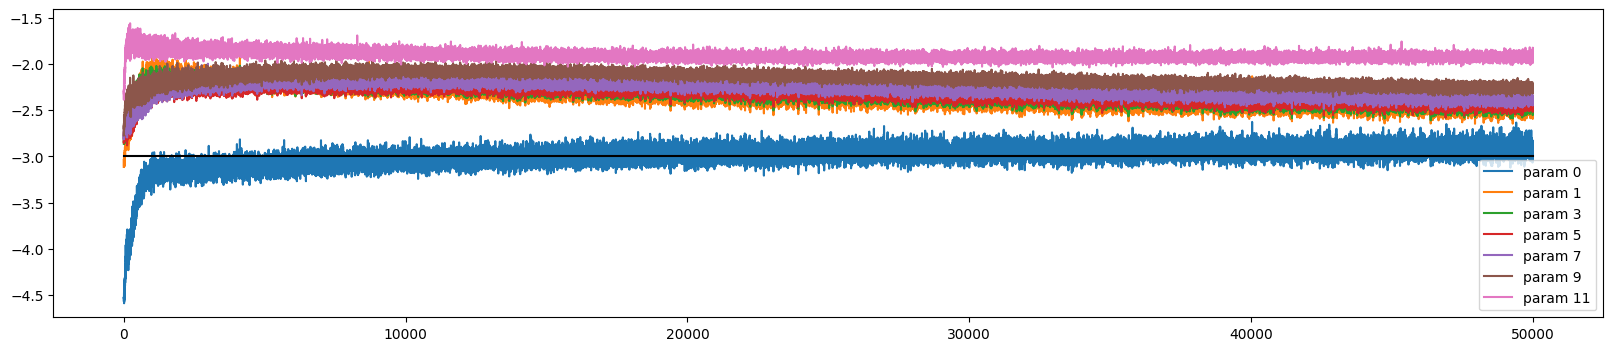

In [104]:
ud.plot()

weight  (30, 100) | mean -0.000254 | std 1.778142e-02 | grad:data ratio 5.134834e-02
weight (100, 100) | mean +0.000179 | std 1.043383e-02 | grad:data ratio 5.559371e-02
weight (100, 100) | mean -0.000025 | std 1.019966e-02 | grad:data ratio 5.705851e-02
weight (100, 100) | mean +0.000066 | std 1.106223e-02 | grad:data ratio 6.375358e-02
weight (100, 100) | mean +0.000054 | std 1.232356e-02 | grad:data ratio 8.169784e-02
weight  (100, 38) | mean -0.000000 | std 2.402255e-02 | grad:data ratio 1.571375e-01


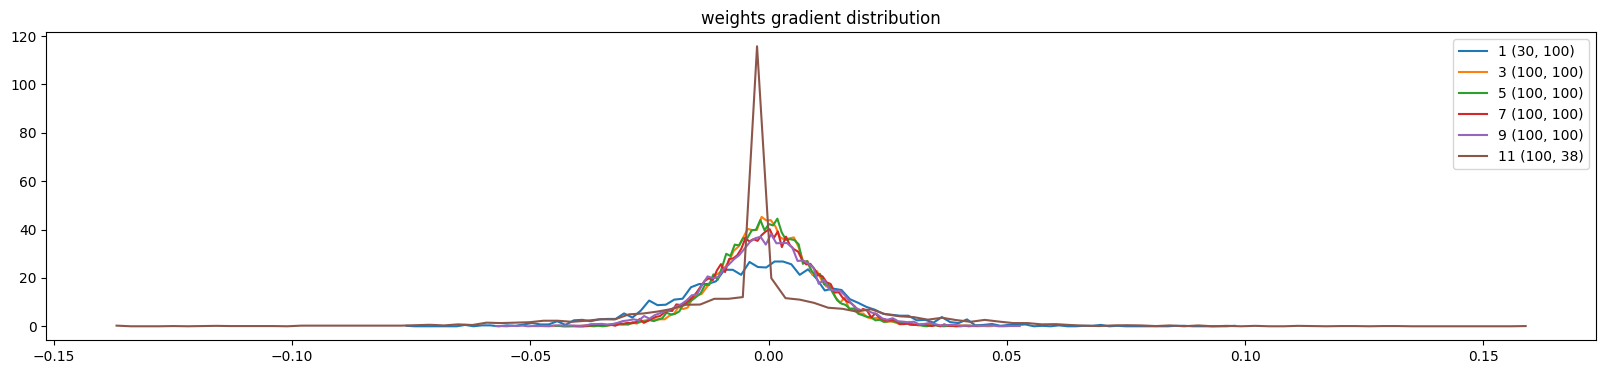

In [105]:
show_weights(mlp)

However when we get to 20 layers it fails to train

  0%|          | 0/5000 [00:00<?, ?it/s]

(3.050510883331299, '124.61% of fixed init loss')

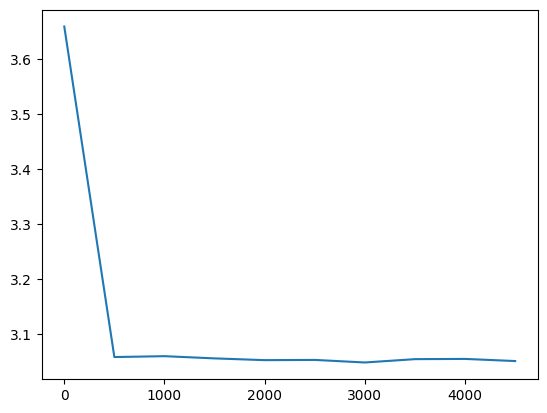

In [106]:
mlp = get_mlp(bias=True, m=10, hs=[100]*20).requires_grad_()

ud = UDCallback()

losses, val_losses = train(mlp, n_step=5_000, lr=lambda step, n_step: 0.1, callback=ud, val_step=500)
val_loss_step, val_loss_value = zip(*val_losses)

plt.plot(val_loss_step, val_loss_value)

l20_loss = val_loss_value[-1]

l20_loss, f'{l20_loss / fix_init_loss:0.2%} of fixed init loss'

The gradients are spread all over the place

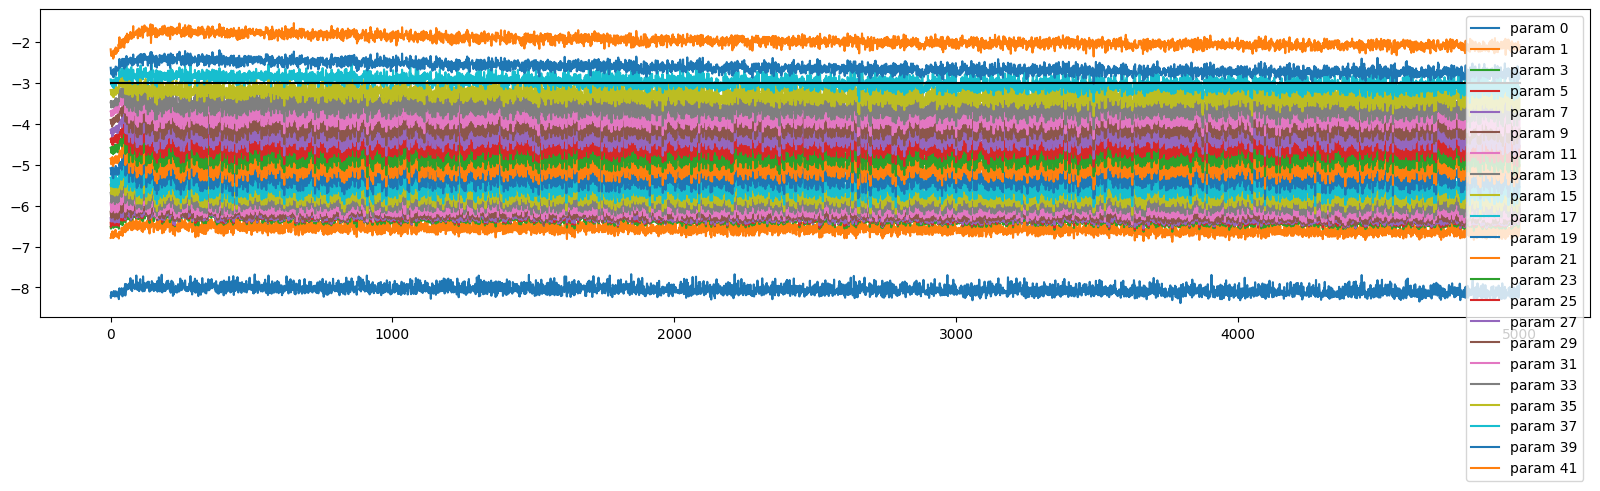

In [107]:
ud.plot()

## Fixing Gain

We can fix the gain within layers and reduce the gain in the final layer to get a better initialisation:

In [108]:
def add_gain(mlp, gain=5/3, output_gain=0.1, update_layers=(MyLinear,)):
    with torch.no_grad():
        for layer in mlp[:-1]:
            if isinstance(layer, update_layers):
                layer.weight *= gain
        mlp[-1].weight *= output_gain

mlp = get_mlp(bias=True, m=10, hs=[100]*5).requires_grad_()
add_gain(mlp, output_gain=0.1)

In [109]:
with torch.no_grad():
    print('Initial Loss: %0.2f' % F.cross_entropy(mlp(X[:1000]), y[:1000]).item())

Initial Loss: 3.65


The layers are more uniform now

layer 3 (MyTanh): mean -0.01, std 0.62, saturated: 2.72%
layer 5 (MyTanh): mean -0.02, std 0.47, saturated: 0.03%
layer 7 (MyTanh): mean 0.01, std 0.39, saturated: 0.00%
layer 9 (MyTanh): mean 0.01, std 0.34, saturated: 0.00%
layer 11 (MyTanh): mean -0.01, std 0.30, saturated: 0.00%


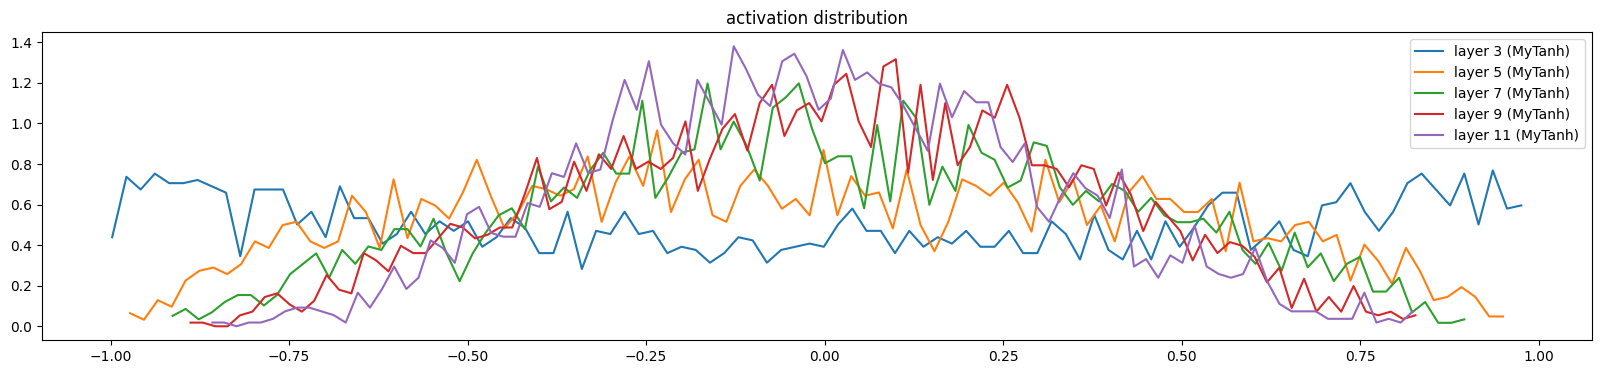

In [110]:
show_layers(mlp)

layer 3 (MyTanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (MyTanh): mean -0.00, std 0.00, saturated: 0.00%
layer 7 (MyTanh): mean 0.00, std 0.00, saturated: 0.00%
layer 9 (MyTanh): mean 0.00, std 0.00, saturated: 0.00%
layer 11 (MyTanh): mean 0.00, std 0.00, saturated: 0.00%


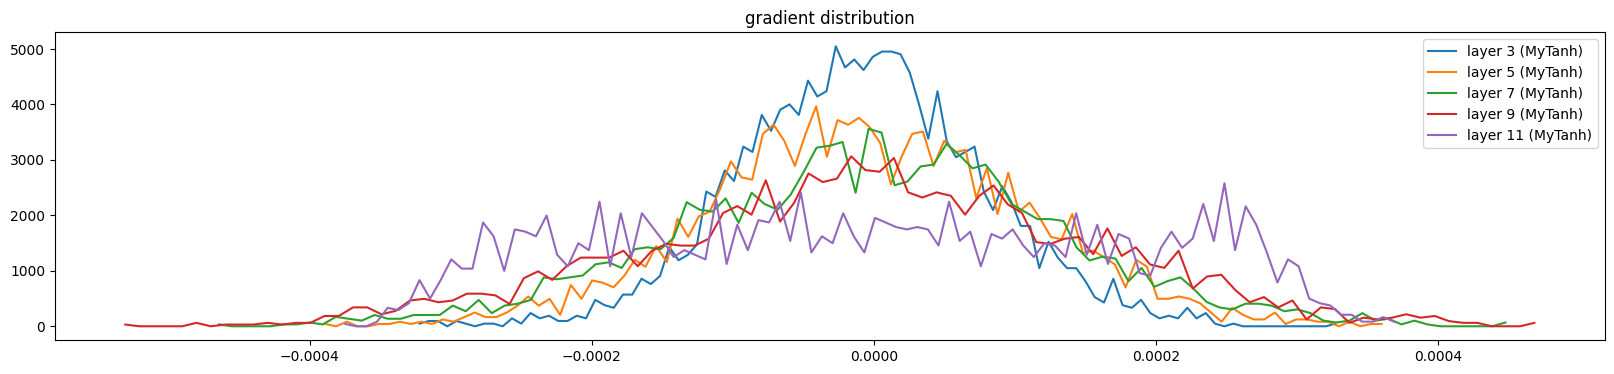

In [111]:
show_layers(mlp, backward=True)

The weights are more uniform except the output layer (because of the multiplication)

weight  (30, 100) | mean +0.000014 | std 3.260477e-04 | grad:data ratio 1.849884e-03
weight (100, 100) | mean +0.000001 | std 3.304202e-04 | grad:data ratio 3.432189e-03
weight (100, 100) | mean -0.000002 | std 3.086994e-04 | grad:data ratio 3.204230e-03
weight (100, 100) | mean +0.000001 | std 3.112402e-04 | grad:data ratio 3.216269e-03
weight (100, 100) | mean -0.000001 | std 3.279222e-04 | grad:data ratio 3.374243e-03
weight  (100, 38) | mean -0.000000 | std 9.346377e-03 | grad:data ratio 1.604743e+00


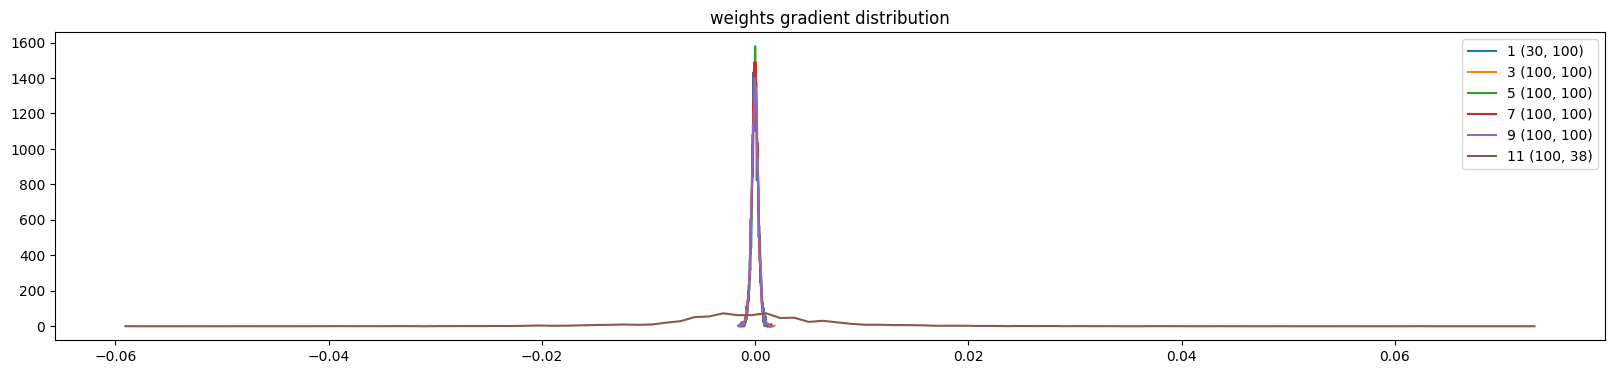

In [112]:
show_weights(mlp)

Let's train it for a little while:

  0%|          | 0/1000 [00:00<?, ?it/s]

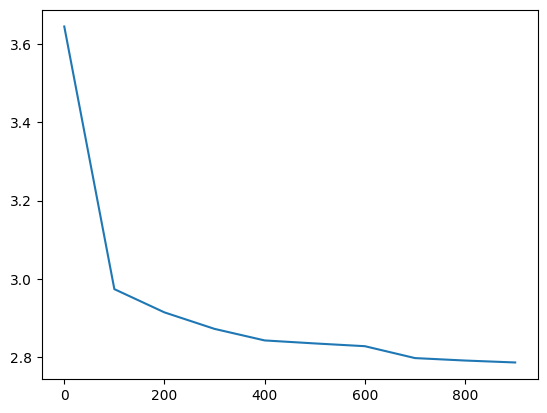

In [113]:
ud = UDCallback()

losses, val_losses = train(mlp, n_step=1_000, lr=lambda step, n_step: 0.1, callback=ud)

val_loss_step, val_loss_value = zip(*val_losses)

plt.plot(val_loss_step, val_loss_value)

The weight updates are similar to before but the weights move more in lockstep during the initial optimisation period

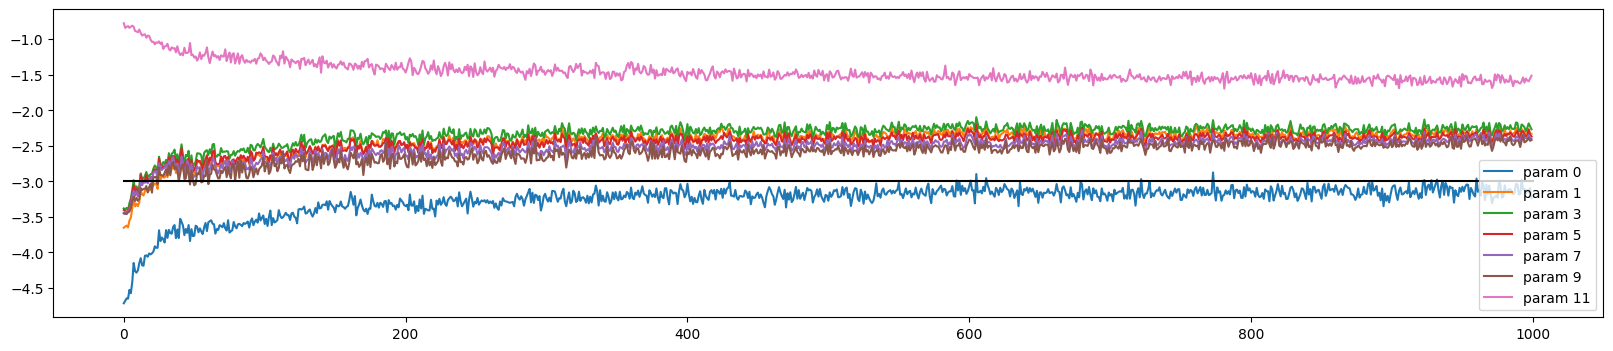

In [114]:
ud.plot()

The output layer gradients comes down across these iterations

weight  (30, 100) | mean -0.000254 | std 1.086286e-02 | grad:data ratio 6.070493e-02
weight (100, 100) | mean +0.000004 | std 7.106286e-03 | grad:data ratio 7.206615e-02
weight (100, 100) | mean +0.000033 | std 5.773973e-03 | grad:data ratio 5.865905e-02
weight (100, 100) | mean -0.000028 | std 5.451859e-03 | grad:data ratio 5.512737e-02
weight (100, 100) | mean +0.000017 | std 5.011663e-03 | grad:data ratio 5.035378e-02
weight  (100, 38) | mean -0.000000 | std 2.294768e-02 | grad:data ratio 3.940181e-01


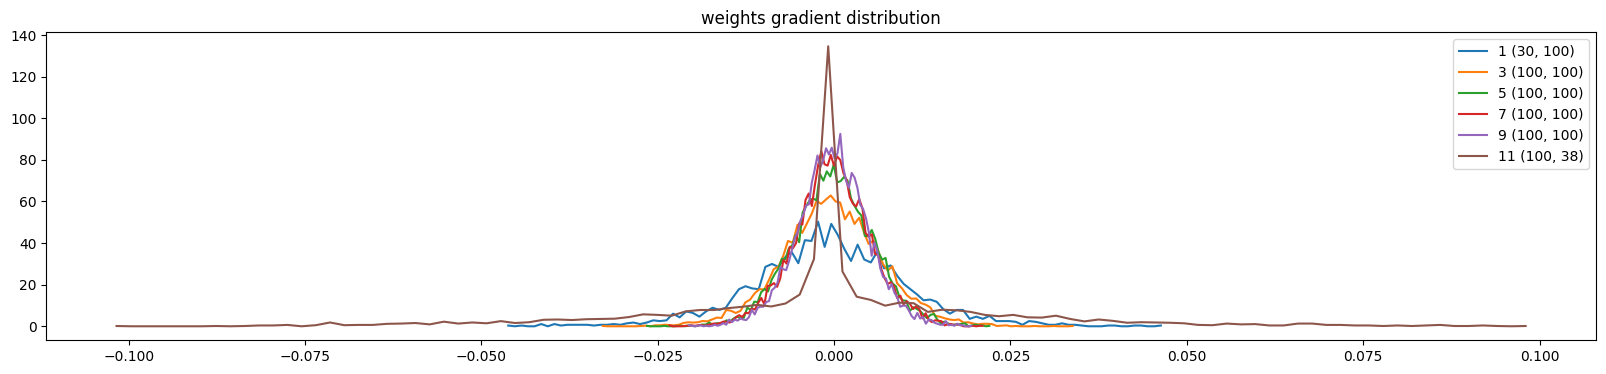

In [115]:
show_weights(mlp, skip_embedding_layer=True)

And the activations and gradients still look good

layer 3 (MyTanh): mean -0.00, std 0.62, saturated: 2.94%
layer 5 (MyTanh): mean -0.04, std 0.51, saturated: 0.25%
layer 7 (MyTanh): mean -0.00, std 0.49, saturated: 0.34%
layer 9 (MyTanh): mean 0.01, std 0.51, saturated: 0.19%
layer 11 (MyTanh): mean 0.02, std 0.55, saturated: 0.66%


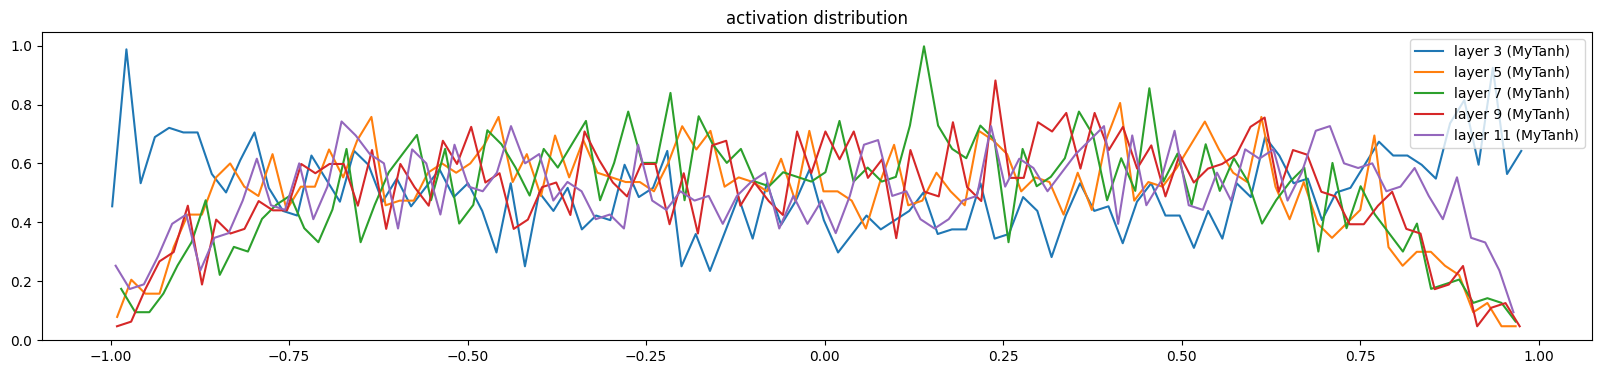

In [116]:
show_layers(mlp)

layer 3 (MyTanh): mean 0.00, std 0.00, saturated: 0.00%
layer 5 (MyTanh): mean -0.00, std 0.00, saturated: 0.00%
layer 7 (MyTanh): mean -0.00, std 0.00, saturated: 0.00%
layer 9 (MyTanh): mean -0.00, std 0.00, saturated: 0.00%
layer 11 (MyTanh): mean 0.00, std 0.00, saturated: 0.00%


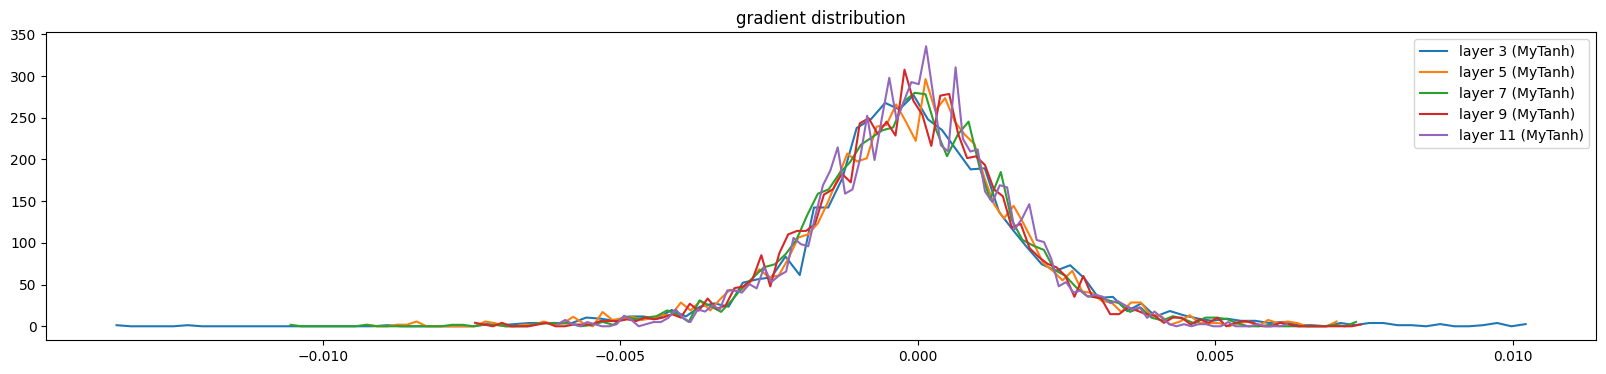

In [117]:
show_layers(mlp, backward=True)

For 5 layers we get a similar result as before

  0%|          | 0/50000 [00:00<?, ?it/s]

(2.4011518955230713, '98.08% of fixed init loss')

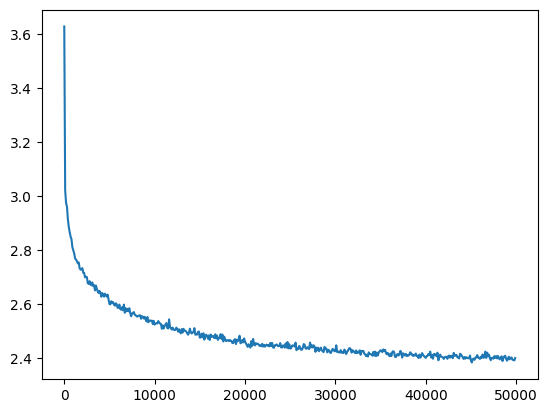

In [118]:
mlp = get_mlp(bias=True, m=10, hs=[100]*5).requires_grad_()
add_gain(mlp, output_gain=0.1)

ud = UDCallback()

losses, val_losses = train(mlp, n_step=50_000, lr=lambda step, n_step: 0.1, callback=ud)

val_loss_step, val_loss_value = zip(*val_losses)

plt.plot(val_loss_step, val_loss_value)

l5_fix_loss = val_loss_value[-1]

l5_fix_loss, f'{l5_fix_loss / fix_init_loss:0.2%} of fixed init loss'

However at 20 layers we get the loss decreasing to a similar level as our 2 layer MLP

  0%|          | 0/50000 [00:00<?, ?it/s]

(2.4759957790374756, '101.14% of fixed init loss')

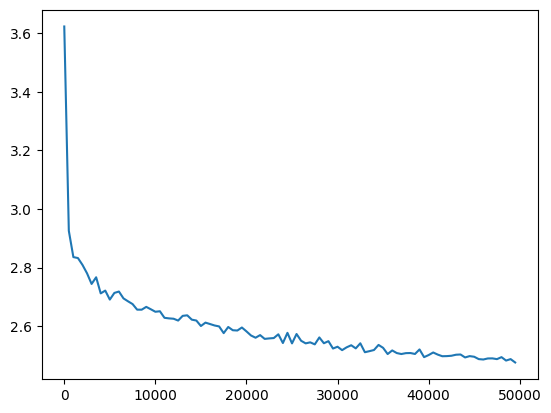

In [119]:
mlp = get_mlp(bias=True, m=10, hs=[100]*20).requires_grad_()
add_gain(mlp)

ud = UDCallback()

losses, val_losses = train(mlp, n_step=50_000, lr=lambda step, n_step: 0.1, callback=ud, val_step=500)
val_loss_step, val_loss_value = zip(*val_losses)

plt.plot(val_loss_step, val_loss_value)

l20_fix_loss = val_loss_value[-1]

l20_fix_loss, f'{l20_fix_loss / fix_init_loss:0.2%} of fixed init loss'

There is still a bit more variance with the updates across layers in this deeper net, but with the better initialisation it is stable

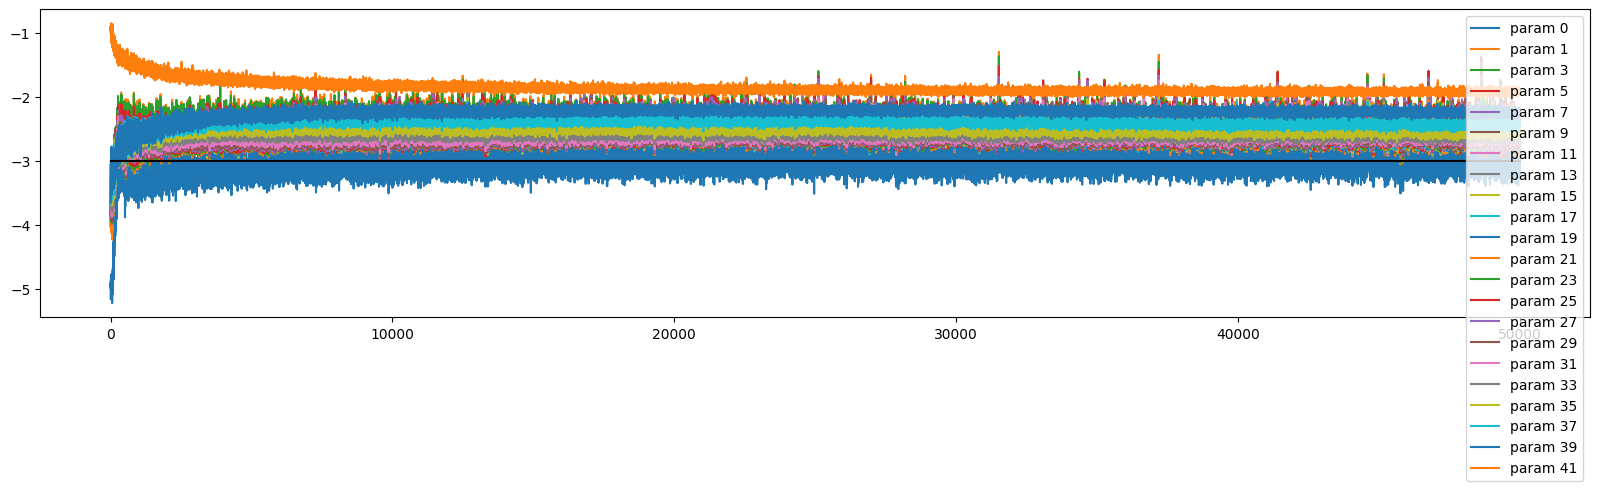

In [120]:
ud.plot()

## Batchnorm

Rather than being careful with initialisation we can use batch norm

In [121]:
mlp = get_mlp(bias=False, m=10, hs=[100]*5, batch_norm=True).requires_grad_()
#add_gain(mlp)

mlp

MySequential((MyEmbedding(38, 10), MyFlatten, MyLinear(30, 100, bias=False), MyBatchNorm1d(100, eps=1e-05, affine=True), MyTanh, MyLinear(100, 100, bias=False), MyBatchNorm1d(100, eps=1e-05, affine=True), MyTanh, MyLinear(100, 100, bias=False), MyBatchNorm1d(100, eps=1e-05, affine=True), MyTanh, MyLinear(100, 100, bias=False), MyBatchNorm1d(100, eps=1e-05, affine=True), MyTanh, MyLinear(100, 100, bias=False), MyBatchNorm1d(100, eps=1e-05, affine=True), MyTanh, MyLinear(100, 38, bias=False), MyBatchNorm1d(38, eps=1e-05, affine=True)))

layer 4 (MyTanh): mean -0.01, std 0.80, saturated: 32.00%
layer 7 (MyTanh): mean -0.00, std 0.83, saturated: 38.72%
layer 10 (MyTanh): mean -0.00, std 0.82, saturated: 34.44%
layer 13 (MyTanh): mean -0.01, std 0.82, saturated: 34.31%
layer 16 (MyTanh): mean -0.01, std 0.82, saturated: 36.94%


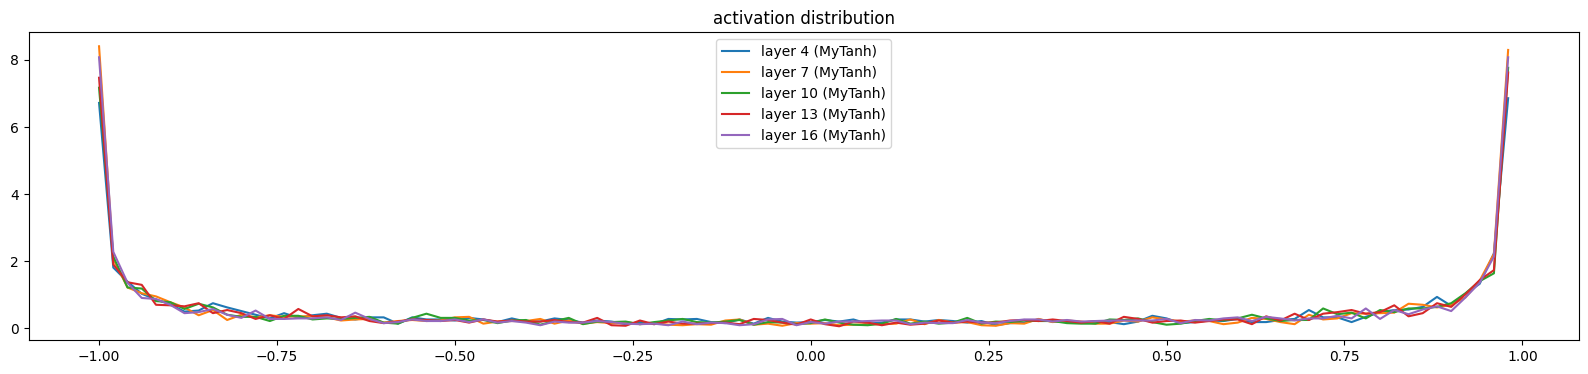

In [122]:
show_layers(mlp)

layer 4 (MyTanh): mean 0.00, std 0.04, saturated: 0.00%
layer 7 (MyTanh): mean 0.00, std 0.03, saturated: 0.00%
layer 10 (MyTanh): mean 0.00, std 0.02, saturated: 0.00%
layer 13 (MyTanh): mean -0.00, std 0.01, saturated: 0.00%
layer 16 (MyTanh): mean 0.00, std 0.01, saturated: 0.00%


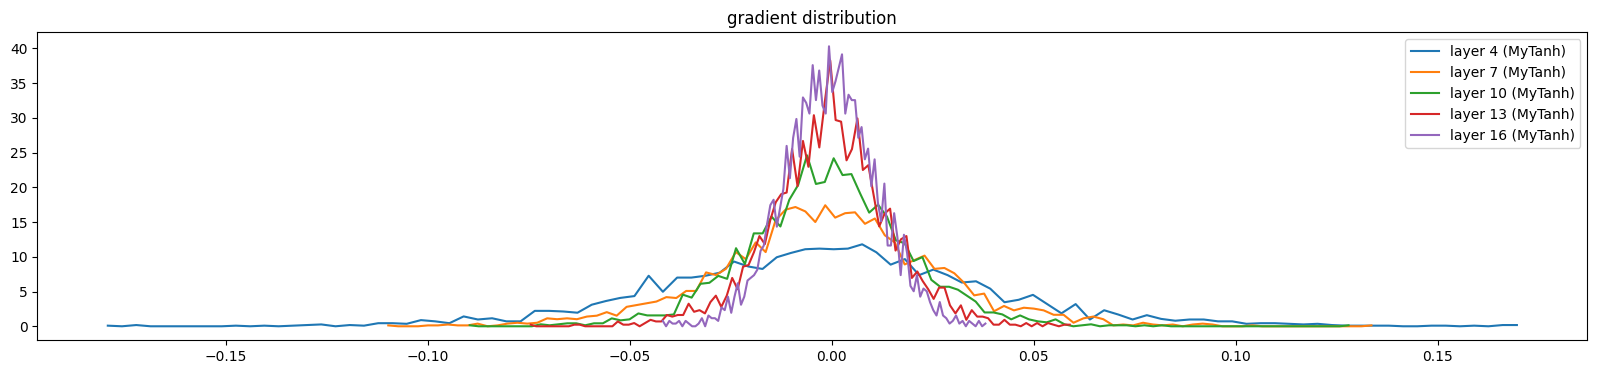

In [123]:
show_layers(mlp, backward=True)

weight  (30, 100) | mean -0.006068 | std 3.976782e-01 | grad:data ratio 3.796145e+00
weight (100, 100) | mean +0.002900 | std 3.224502e-01 | grad:data ratio 5.585790e+00
weight (100, 100) | mean +0.002294 | std 2.273206e-01 | grad:data ratio 3.929580e+00
weight (100, 100) | mean +0.000491 | std 1.619342e-01 | grad:data ratio 2.798622e+00
weight (100, 100) | mean -0.000863 | std 1.270476e-01 | grad:data ratio 2.212344e+00
weight  (100, 38) | mean +0.002701 | std 1.532580e-01 | grad:data ratio 2.657254e+00


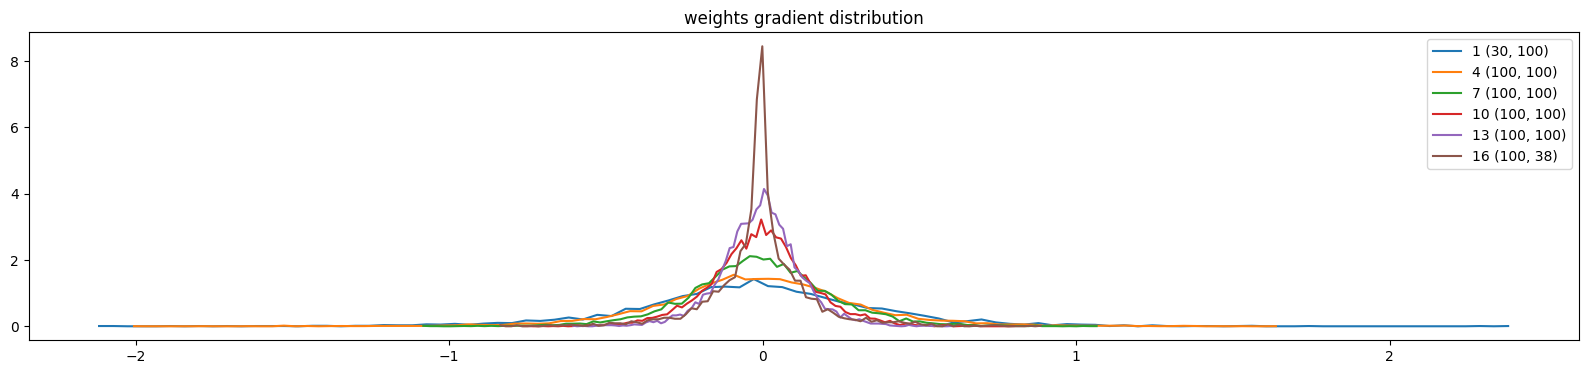

In [124]:
show_weights(mlp)

  0%|          | 0/1000 [00:00<?, ?it/s]

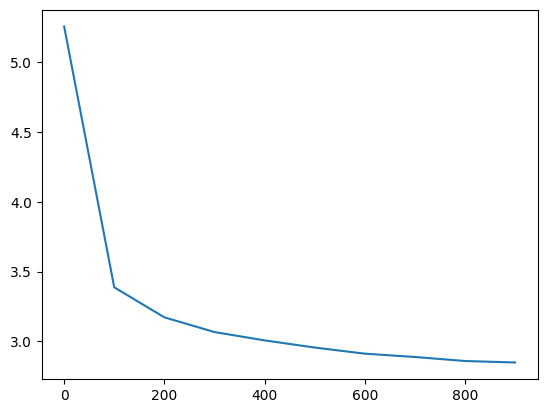

In [125]:
ud = UDCallback()

losses, val_losses = train(mlp, n_step=1_000, lr=lambda step, n_step: 0.1, callback=ud)

val_loss_step, val_loss_value = zip(*val_losses)

plt.plot(val_loss_step, val_loss_value)

The training looks more stable

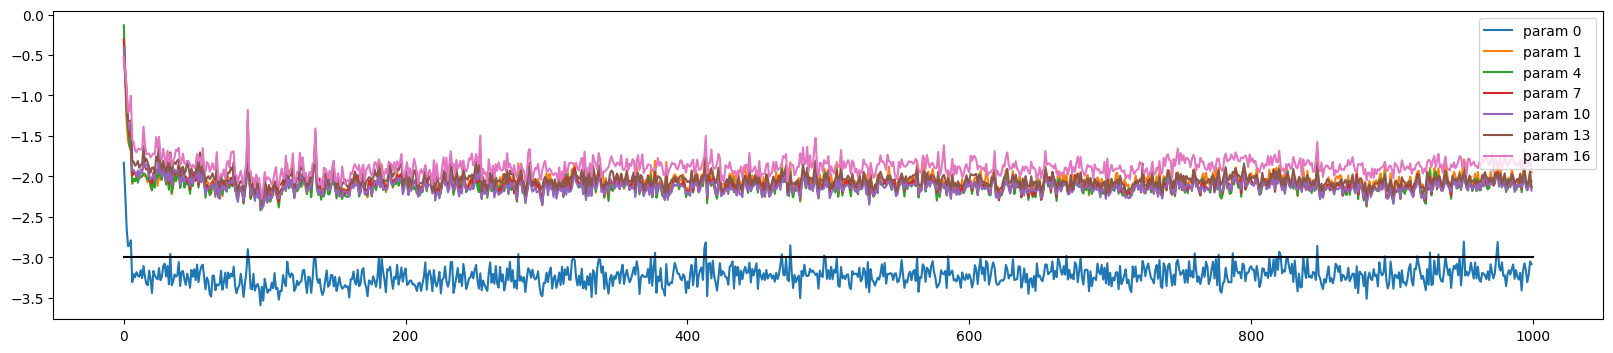

In [126]:
ud.plot()

The saturation quickly reduces

layer 4 (MyTanh): mean -0.00, std 0.76, saturated: 20.53%
layer 7 (MyTanh): mean -0.01, std 0.68, saturated: 8.31%
layer 10 (MyTanh): mean 0.01, std 0.74, saturated: 16.50%
layer 13 (MyTanh): mean 0.00, std 0.73, saturated: 12.87%
layer 16 (MyTanh): mean -0.01, std 0.74, saturated: 12.53%


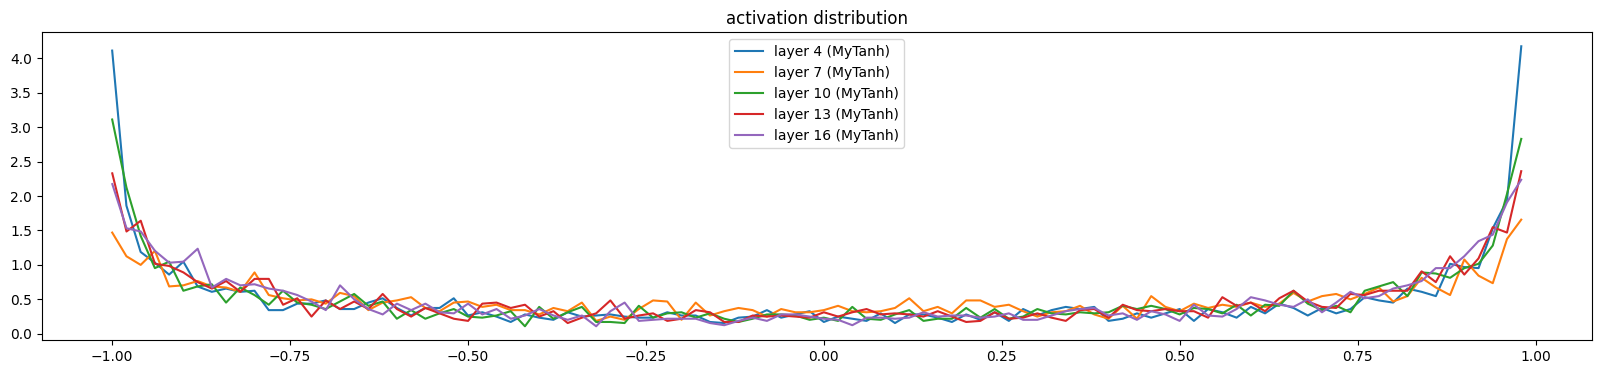

In [127]:
show_layers(mlp)

And we get a similar result when we train for a long time

  0%|          | 0/50000 [00:00<?, ?it/s]

(2.4429738521575928, '99.79% of fixed init loss')

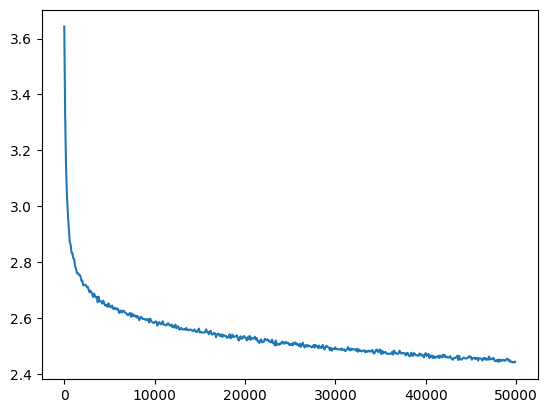

In [128]:
mlp = get_mlp(batch_norm=True, bias=False, m=10, hs=[100]*5).requires_grad_()
add_gain(mlp, output_gain=0.1)

ud = UDCallback()

losses, val_losses = train(mlp, n_step=50_000, lr=lambda step, n_step: 0.1, callback=ud)

val_loss_step, val_loss_value = zip(*val_losses)

plt.plot(val_loss_step, val_loss_value)

l5_bn_loss = val_loss_value[-1]

l5_bn_loss, f'{l5_bn_loss / fix_init_loss:0.2%} of fixed init loss'

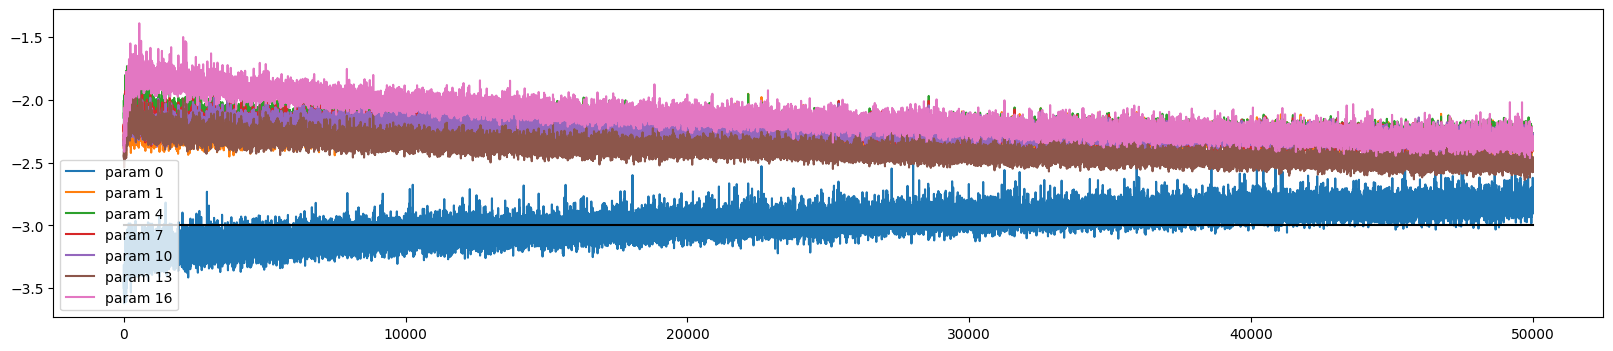

In [129]:
ud.plot()

And it successfully trains a 20 layer network too

  0%|          | 0/50000 [00:00<?, ?it/s]

(2.5574026107788086, '104.47% of fixed init loss')

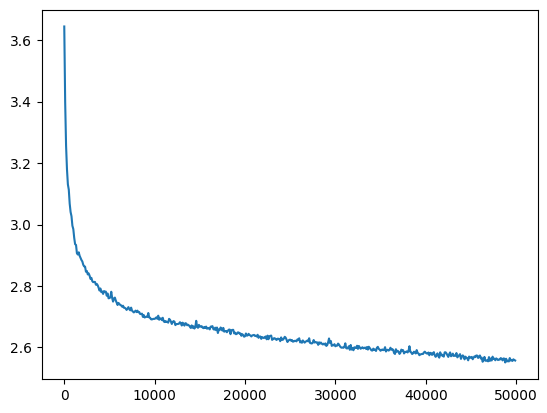

In [130]:
mlp = get_mlp(batch_norm=True, bias=False, m=10, hs=[100]*20).requires_grad_()
add_gain(mlp, output_gain=0.1)

ud = UDCallback()

losses, val_losses = train(mlp, n_step=50_000, lr=lambda step, n_step: 0.1, callback=ud)

val_loss_step, val_loss_value = zip(*val_losses)

plt.plot(val_loss_step, val_loss_value)

l20_bn_loss = val_loss_value[-1]

l20_bn_loss, f'{l20_bn_loss / fix_init_loss:0.2%} of fixed init loss'

# Using PyTorch nn Library

We can easily reuse Torch's implementations which are likely more efficient

In [131]:
from torch.nn import Module, Linear, Embedding, Tanh, BatchNorm1d, Sequential, Flatten

def get_mlp(m=default_m, hs=(default_h,), batch_norm=False, bias=False, V=V, block_size=block_size, activation_factory=lambda: Tanh()):
    # First we embed the vectors and then flatten them
    layers = [Embedding(V, m), Flatten()]
    
    # Then add the hidden layers
    in_sizes = [block_size * m] + list(hs)
    out_sizes = list(hs) + [V]
    for h_in, h_out in zip(in_sizes, out_sizes):
        layers.append(Linear(h_in, h_out, bias=bias))
        if batch_norm:
            layers.append(BatchNorm1d(num_features=h_out))
        layers.append(activation_factory())
    # Drop the last activation, since this is passed to Softmax
    layers.pop()

    return Sequential(*layers)

mlp = get_mlp(bias=True, m=10, hs=[100]*5).requires_grad_()
mlp

Sequential(
  (0): Embedding(38, 10)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=30, out_features=100, bias=True)
  (3): Tanh()
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): Tanh()
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): Tanh()
  (8): Linear(in_features=100, out_features=100, bias=True)
  (9): Tanh()
  (10): Linear(in_features=100, out_features=100, bias=True)
  (11): Tanh()
  (12): Linear(in_features=100, out_features=38, bias=True)
)

However we can't show the layers the same way as before because PyTorch doesn't store results in `.out`

In [132]:
try:
    show_layers(mlp, classes=(Tanh,))
except AttributeError as e:
    print(e)

'Tanh' object has no attribute 'out'


<Figure size 2000x400 with 0 Axes>

However PyTorch provides a mechanism to modify the behaviour of a module without editing the source code: hooks.

We can register a [forward hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_forward_hook) to capture the output:


In [133]:
def log_output(module, args, output):
    module.out = output

for layer in mlp:
    if isinstance(layer, Tanh):
        layer.register_forward_hook(log_output)

And then use our functions as before:

layer 3 (Tanh()): mean -0.03, std 0.49, saturated: 0.37%
layer 5 (Tanh()): mean -0.01, std 0.26, saturated: 0.00%
layer 7 (Tanh()): mean -0.01, std 0.16, saturated: 0.00%
layer 9 (Tanh()): mean -0.01, std 0.11, saturated: 0.00%
layer 11 (Tanh()): mean -0.02, std 0.08, saturated: 0.00%


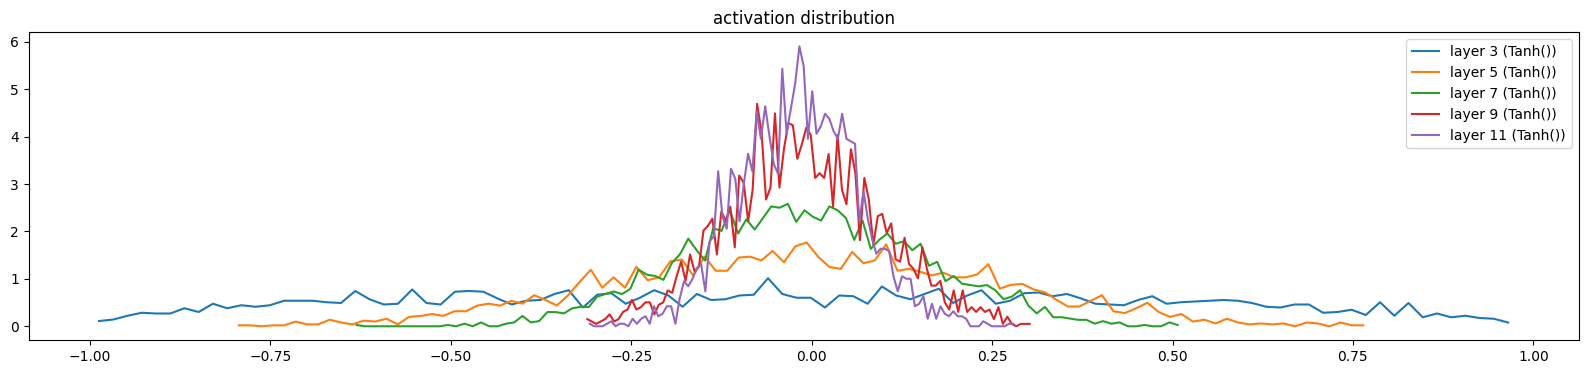

In [134]:
show_layers(mlp, classes=(Tanh,))

layer 3 (Tanh()): mean 0.00, std 0.00, saturated: 0.00%
layer 5 (Tanh()): mean 0.00, std 0.00, saturated: 0.00%
layer 7 (Tanh()): mean 0.00, std 0.00, saturated: 0.00%
layer 9 (Tanh()): mean 0.00, std 0.00, saturated: 0.00%
layer 11 (Tanh()): mean 0.00, std 0.00, saturated: 0.00%


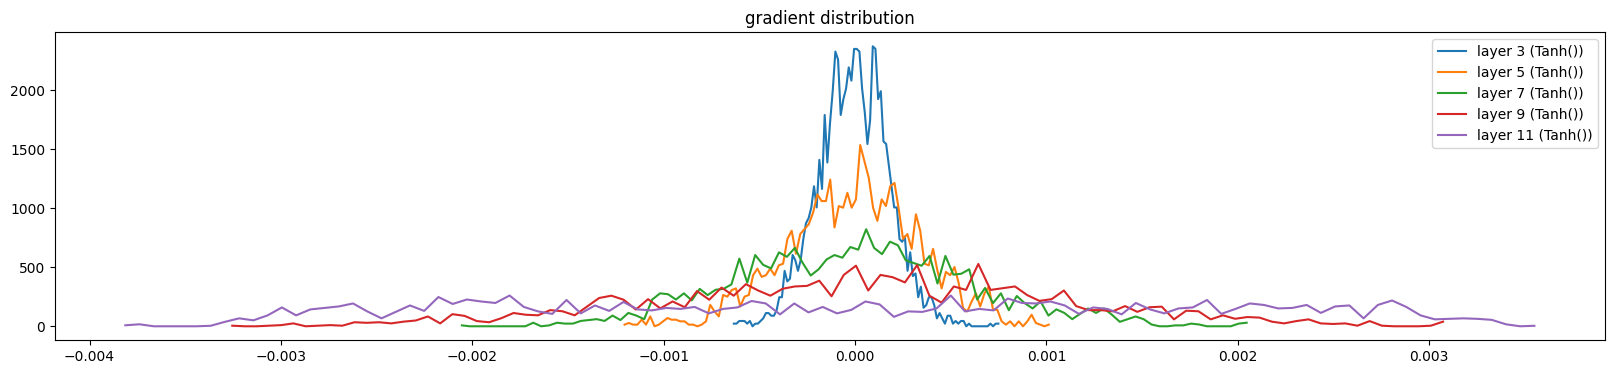

In [135]:
show_layers(mlp, backward=True, classes=(Tanh,))

weight  (100, 30) | mean -0.000007 | std 1.011561e-03 | grad:data ratio 9.519964e-03
weight (100, 100) | mean -0.000002 | std 1.124272e-03 | grad:data ratio 1.947545e-02
weight (100, 100) | mean -0.000002 | std 1.041845e-03 | grad:data ratio 1.801275e-02
weight (100, 100) | mean -0.000002 | std 1.207655e-03 | grad:data ratio 2.074841e-02
weight (100, 100) | mean -0.000012 | std 1.380317e-03 | grad:data ratio 2.384296e-02
weight  (38, 100) | mean -0.000000 | std 3.135142e-03 | grad:data ratio 5.340258e-02


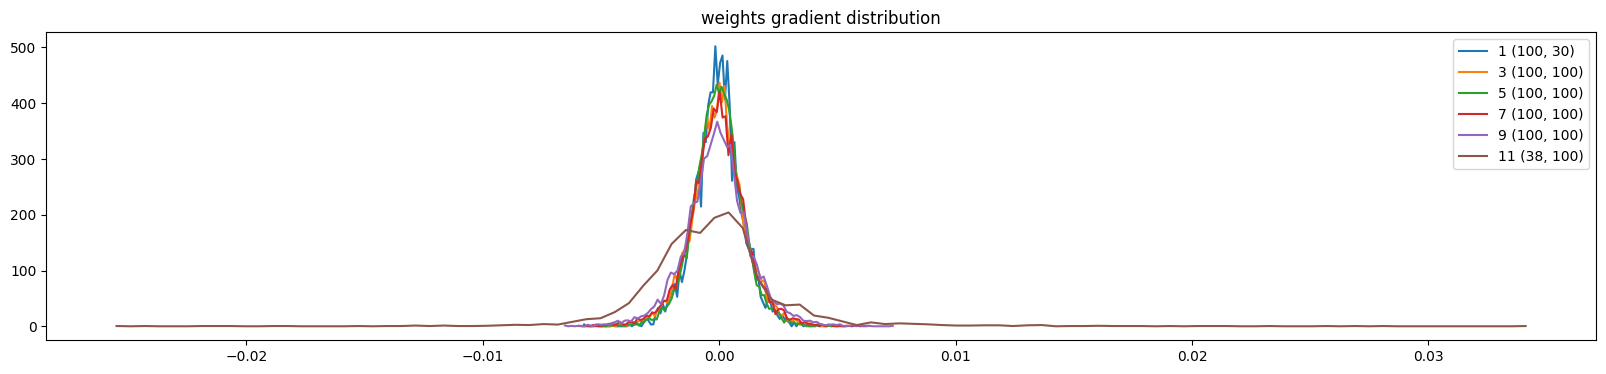

In [136]:
show_weights(mlp)

We can fix the weights as before, updating Linear (rather than MyLinear) layers:

In [137]:
add_gain(mlp, output_gain=0.1, update_layers=(Linear,))

layer 3 (Tanh()): mean -0.03, std 0.64, saturated: 5.59%
layer 5 (Tanh()): mean -0.00, std 0.47, saturated: 0.12%
layer 7 (Tanh()): mean -0.01, std 0.39, saturated: 0.00%
layer 9 (Tanh()): mean -0.01, std 0.33, saturated: 0.00%
layer 11 (Tanh()): mean -0.01, std 0.30, saturated: 0.00%


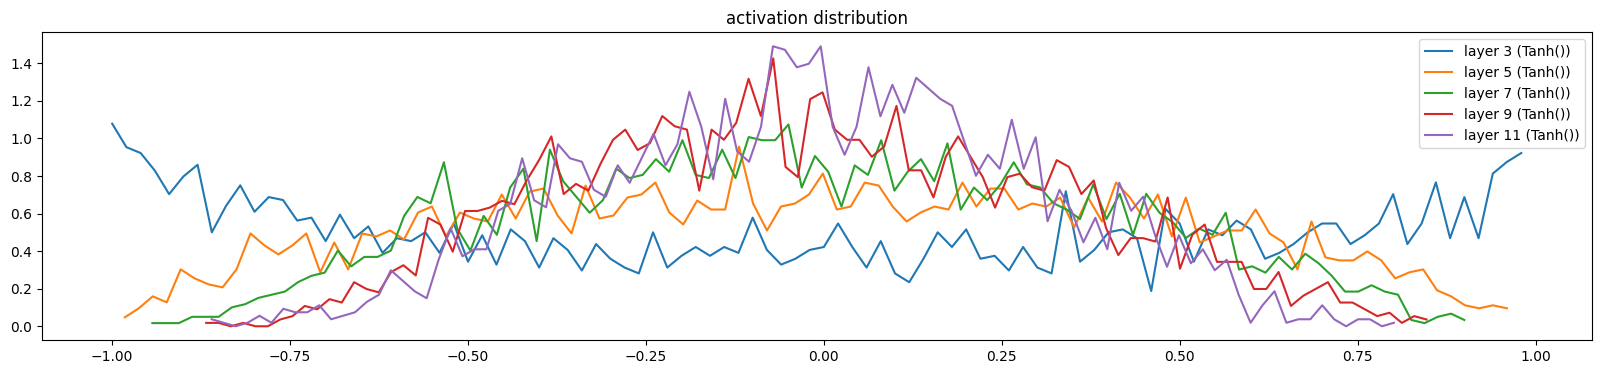

In [138]:
show_layers(mlp, classes=(Tanh,))

layer 3 (Tanh()): mean 0.00, std 0.00, saturated: 0.00%
layer 5 (Tanh()): mean 0.00, std 0.00, saturated: 0.00%
layer 7 (Tanh()): mean 0.00, std 0.00, saturated: 0.00%
layer 9 (Tanh()): mean 0.00, std 0.00, saturated: 0.00%
layer 11 (Tanh()): mean 0.00, std 0.00, saturated: 0.00%


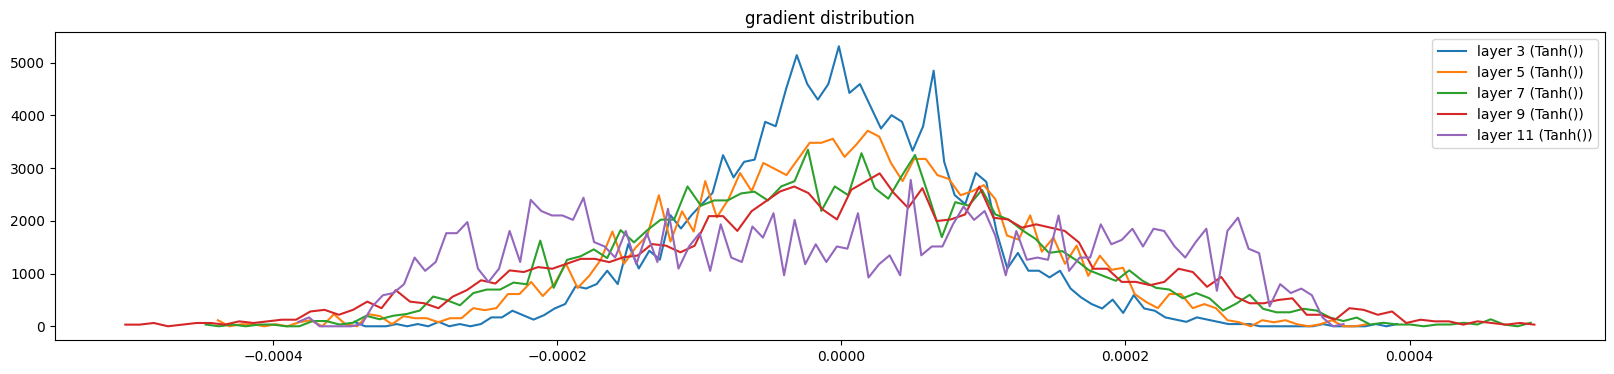

In [139]:
show_layers(mlp, backward=True, classes=(Tanh,))

weight  (100, 30) | mean -0.000002 | std 4.227582e-04 | grad:data ratio 2.387187e-03
weight (100, 100) | mean -0.000001 | std 4.307418e-04 | grad:data ratio 4.476971e-03
weight (100, 100) | mean +0.000000 | std 3.819067e-04 | grad:data ratio 3.961735e-03
weight (100, 100) | mean +0.000001 | std 3.799068e-04 | grad:data ratio 3.916249e-03
weight (100, 100) | mean -0.000004 | std 3.589212e-04 | grad:data ratio 3.719902e-03
weight  (38, 100) | mean +0.000000 | std 9.675195e-03 | grad:data ratio 1.648029e+00


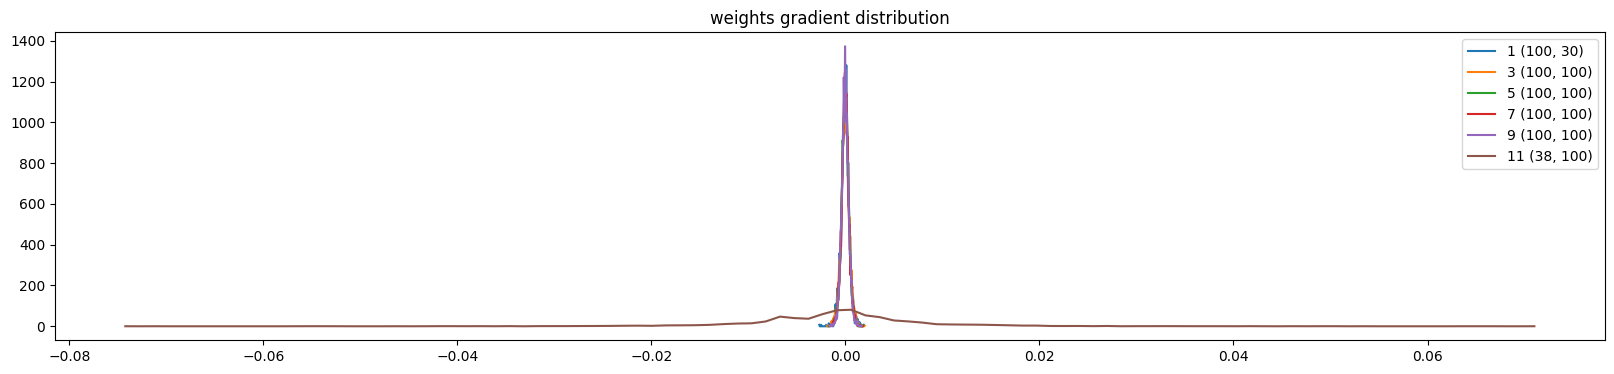

In [140]:
show_weights(mlp)

And training is exactly the same:

  0%|          | 0/50000 [00:00<?, ?it/s]

(2.4006731510162354, '99.98% of l5 fixed loss')

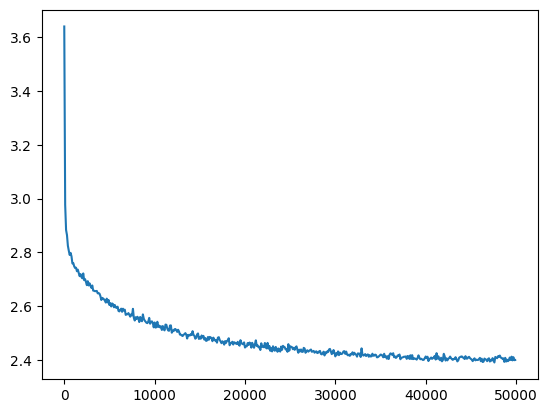

In [141]:
ud = UDCallback()

losses, val_losses = train(mlp, n_step=50_000, lr=lambda step, n_step: 0.1, callback=ud)

val_loss_step, val_loss_value = zip(*val_losses)

plt.plot(val_loss_step, val_loss_value)

l5_torch_loss = val_loss_value[-1]

l5_torch_loss, f'{l5_torch_loss / l5_fix_loss:0.2%} of l5 fixed loss'

We can plot the update dynamics and it looks similar to before

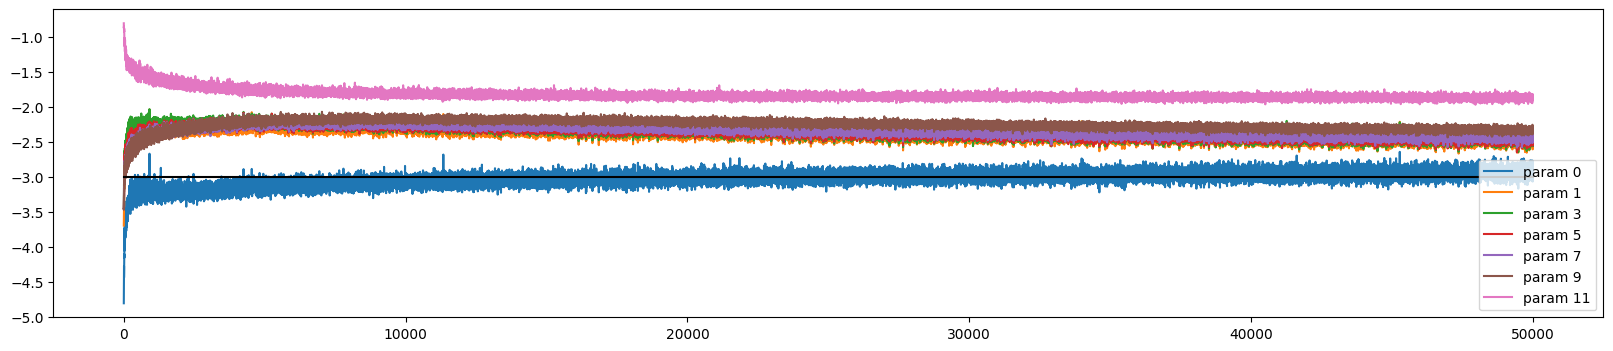

In [142]:
ud.plot()

## Batchnorm

Similarly we can train with batchnorm

  0%|          | 0/50000 [00:00<?, ?it/s]

(2.3883166313171387, '97.76% of l5 batchnorm loss')

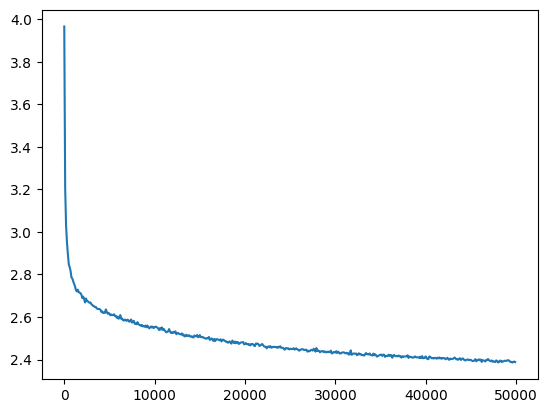

In [143]:
mlp = get_mlp(batch_norm=True, bias=False, m=10, hs=[100]*5).requires_grad_()

ud = UDCallback()

losses, val_losses = train(mlp, n_step=50_000, lr=lambda step, n_step: 0.1, callback=ud)

val_loss_step, val_loss_value = zip(*val_losses)

plt.plot(val_loss_step, val_loss_value)

l5_torch_bn_loss = val_loss_value[-1]

l5_torch_bn_loss, f'{l5_torch_bn_loss / l5_bn_loss:0.2%} of l5 batchnorm loss'

## Training a 5 layer network

Put it all together let's see how low we can make the loss

In [144]:
mlp = get_mlp(bias=True, m=default_m, hs=[default_h]*5).requires_grad_()
add_gain(mlp, update_layers=(Linear,))

Let's check the initialisation:

In [145]:
hooks = []

for layer in mlp:
    if isinstance(layer, Tanh):
        hooks.append(layer.register_forward_hook(log_output))

layer 3 (Tanh()): mean 0.00, std 0.61, saturated: 2.58%
layer 5 (Tanh()): mean -0.00, std 0.46, saturated: 0.02%
layer 7 (Tanh()): mean -0.01, std 0.37, saturated: 0.00%
layer 9 (Tanh()): mean 0.01, std 0.32, saturated: 0.00%
layer 11 (Tanh()): mean -0.00, std 0.28, saturated: 0.00%


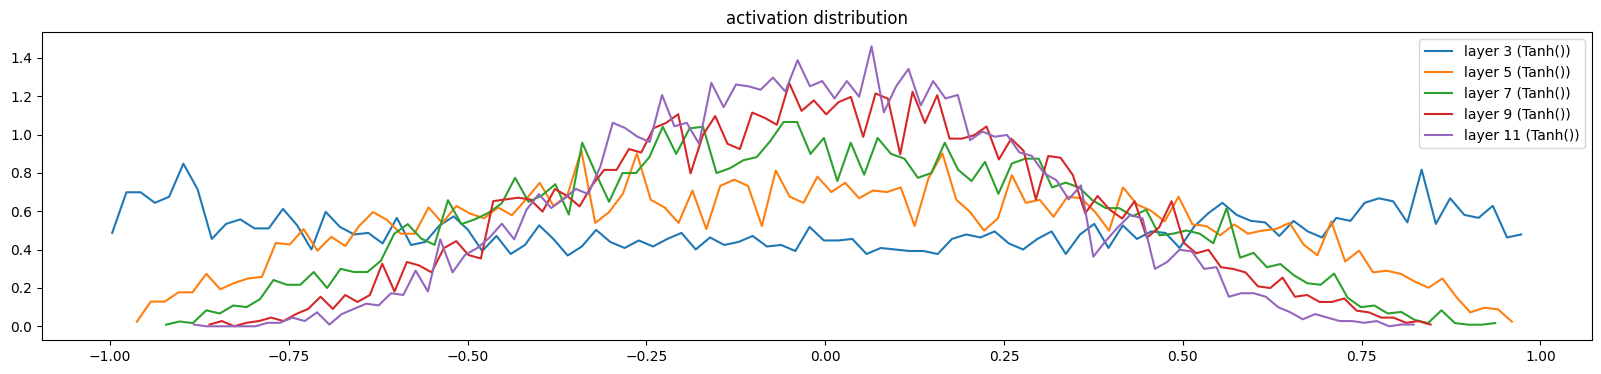

In [146]:
show_layers(mlp, classes=(Tanh,))

layer 3 (Tanh()): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (Tanh()): mean -0.00, std 0.00, saturated: 0.00%
layer 7 (Tanh()): mean -0.00, std 0.00, saturated: 0.00%
layer 9 (Tanh()): mean 0.00, std 0.00, saturated: 0.00%
layer 11 (Tanh()): mean -0.00, std 0.00, saturated: 0.00%


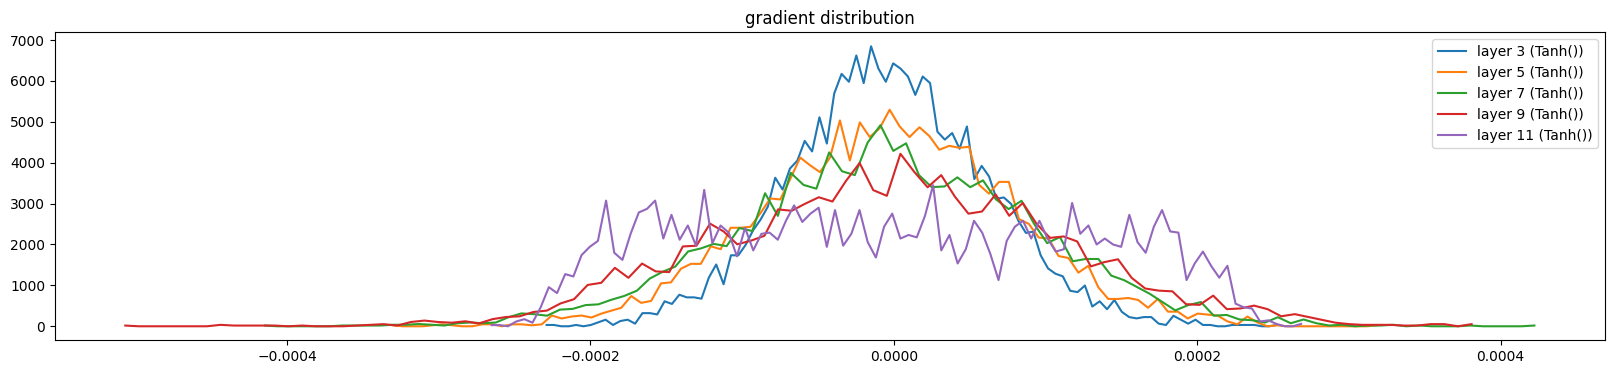

In [147]:
show_layers(mlp, classes=(Tanh,), backward=True)

Remove the hooks so we don't need to store any unnecessary outputs

In [148]:
for hook in hooks:
    hook.remove()

We'll train it for a lot longer and get a slightly lower loss

  0%|          | 0/200000 [00:00<?, ?it/s]

(2.3479623794555664, '95.91% of fixed init loss')

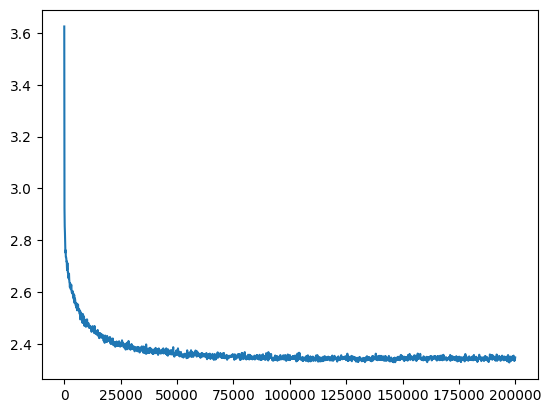

In [149]:
ud = UDCallback()

losses, val_losses = train(mlp, n_step=200_000, lr=lambda step, n_step: 0.1, callback=ud)
val_loss_step, val_loss_value = zip(*val_losses)

plt.plot(val_loss_step, val_loss_value)

aloss = val_loss_value[-1]

aloss, f'{aloss / fix_init_loss:0.2%} of fixed init loss'

At the end the training has converged

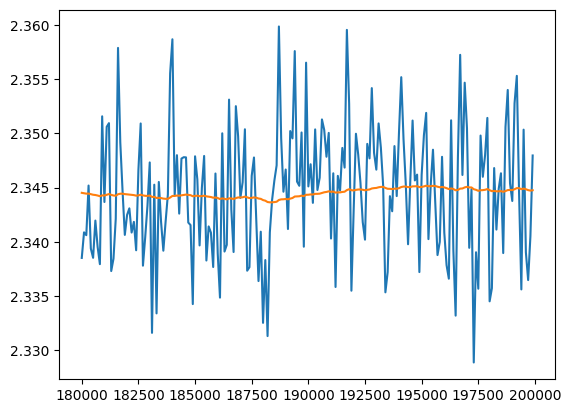

In [150]:
val_loss_ema = [val_loss_value[0]]
momentum = 0.01

for v in val_loss_value[1:]:
    val_loss_ema.append(val_loss_ema[-1] * (1 - momentum) + v * momentum)

plt.plot(val_loss_step[-200:], val_loss_value[-200:])
plt.plot(val_loss_step[-200:], val_loss_ema[-200:])

These are looking slightly more human readable, and some are good, but in general don't have long range coherence, suggesting that context length is the bottleneck.

In [151]:
for _ in range(20):
    print(sample(mlp))

star
worldonteslangendownpolittersing
wegamepiand_ete
bey_babybugramberdenvanceanimedynews
wresiranugue
disabamazmongonpraxgifsonavioloningwael
windian_botlauker
digifs
kawallorestages
mildlanenoumusicess
slustsurveeupjobbyhbosfronthavirthoppromartyle
eding
blianquely
lone
djerkfries
blacebakinds
knerdups
mints
thedomniada
tecons


# What next?

We have looked closer at how the weights change during training, and how initialisation and batch norm can keep the weights in a better range during training.
We've also changed everything into pure PyTorch and added some instrumentation for checking how weights and gradients change over time.

What we haven't done is substantially reduced the loss; for this we're likely going to need more than 3 characters of context